Jupyter notebook к докладу https://slides.ooni.io/2018/cif/

Цветовое кодирование:
- серый &mdash; единичные измерения поступающие от пробников RIPE Atlas
- чёрный &mdash; портскан с адреса `178.176.30.221`
- синий &mdash; `ts=` из блоклиста РКН, совпадает со значением `ts=` в "дэльтах"
- красный &mdash; примерное время блокировки на конкретном пробнике RIPE Atlas

In [1]:
PROBE_PLOT = True
experiment = 's5tg-02'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from pytz import reference
TZ = reference.LocalTimezone()

In [4]:
import pandas as pd
import requests
from scipy.optimize import minimize_scalar

In [5]:
rkn_ts = {
    #<ip ts="2018-09-20T03:30:00+03:00">45.56.118.171</ip>
    # no RIPE Atlas data
    #<ip ts="2018-09-20T17:01:00+03:00">66.175.214.174</ip>
    '66.175.214.174:1080': 1537452060,
    #<ip ts="2018-09-20T17:01:00+03:00">45.33.100.246</ip>
    '45.33.100.246:27435': 1537452060,
    #<ip ts="2018-09-20T21:28:00+03:00">104.200.21.102</ip>
    '104.200.21.102:15197': 1537468080,
    #<ip ts="2018-09-21T01:20:00+03:00">173.255.215.241</ip>
    '173.255.215.241:24914': 1537482000,
}
scan_ts = {
    '45.56.118.171:1080': 1537392745, # no RIPE Atlas data
    '66.175.214.174:1080': 1537445876,
    '45.33.100.246:27435': 1537445708,
    '104.200.21.102:15197': 1537464296,
    '173.255.215.241:24914': 1537473342,
}

In [6]:
d = pd.read_json('{}-full.jsonl'.format(experiment), lines=True)
d.head()

,cert,cert_len,dst,from,prb_id,stored_timestamp,timestamp
0,-----BEGIN CERTIFICATE-----\nMIICyDCCAbCgAwIBA...,1,66.175.214.174:1080,193.232.224.27,10059,1537443177,2018-09-20 11:31:41
1,-----BEGIN CERTIFICATE-----\nMIICyDCCAbCgAwIBA...,1,66.175.214.174:1080,193.232.224.27,10059,1537443343,2018-09-20 11:34:43
2,-----BEGIN CERTIFICATE-----\nMIICyDCCAbCgAwIBA...,1,66.175.214.174:1080,193.232.224.27,10059,1537443617,2018-09-20 11:37:39
3,-----BEGIN CERTIFICATE-----\nMIICyDCCAbCgAwIBA...,1,66.175.214.174:1080,193.232.224.27,10059,1537443759,2018-09-20 11:40:43
4,-----BEGIN CERTIFICATE-----\nMIICyDCCAbCgAwIBA...,1,66.175.214.174:1080,193.232.224.27,10059,1537443901,2018-09-20 11:43:48


In [7]:
if hasattr(d, 'dst'):
    dst = d.dst[0]
    print 'del dst', dst
    blue_line = rkn_ts[dst] * 1000000000
    scan_line = scan_ts[dst] * 1000000000
    assert d.dst.nunique() == 1
    del d['dst']
blue_dt = pd.to_datetime(blue_line, unit='ns')
scan_dt = pd.to_datetime(scan_line, unit='ns')
if not hasattr(d, 'good_cert'):
    known_certs = d.groupby('cert').cert.nunique()
    good_cert = max(dict(known_certs).items(), key=lambda _: _[1])[0]
    print 'add good_cert'
    d['good_cert'] = (d.cert == good_cert)
    print 'del cert'
    del d['cert']
if not hasattr(d, 'stored_utc'):
    print 'add stored_utc'
    d['stored_utc'] = pd.to_datetime(d.stored_timestamp, unit='s')

del dst 66.175.214.174:1080
add good_cert
del cert
add stored_utc


In [8]:
(d.stored_utc - d.timestamp).describe()

count                     19062
mean     0 days 00:01:40.606337
std      0 days 00:01:01.398470
min             0 days 00:00:00
25%             0 days 00:01:05
50%             0 days 00:01:37
75%             0 days 00:02:12
max             0 days 01:22:46
dtype: object

В некоторый момент с части пробников измерения были сняты, т.к. на данных пробах блокировка уже наступила и тратить RIPE Atlas кредиты на них не имело смысла. Пробы, с которых сигнал о блокировке ещё не был получен, продолжали генерировать измерения.

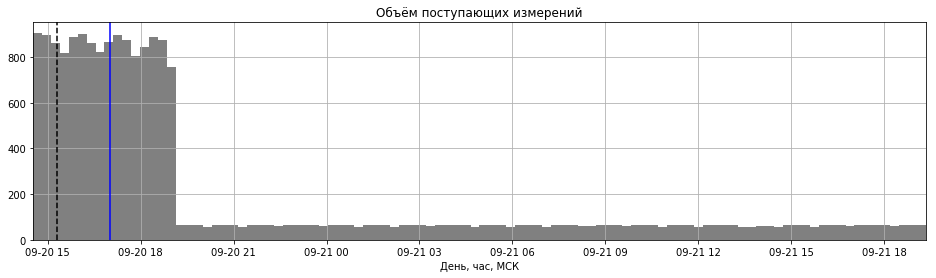

In [9]:
f = figure(figsize=(16,4))
axvline(blue_dt, color='blue')
axvline(scan_dt, color='black', ls='--')
xlim(d.timestamp.min(), d.timestamp.max())
f.axes[0].xaxis_date(TZ)
d.timestamp.hist(bins=100, color='grey')
title(u'Объём поступающих измерений')
xlabel(u'День, час, МСК')
show()

In [10]:
red_line = {} # prb_id -> timestamp

for prb_id in d.prb_id.unique():
    prb = d[d.prb_id == prb_id]
    yorig = prb.good_cert.astype('int')
    xorig = prb.timestamp.astype('int64')
    def separator_cost(x):
        cls = (xorig < x).astype('int')
        return (yorig != cls).sum()
    sol = minimize_scalar(separator_cost, bounds=(xorig.min(), xorig.max()), method='Bounded')
    assert sol.success == True
    red_line[prb_id] = sol.x

prb_id: 20873


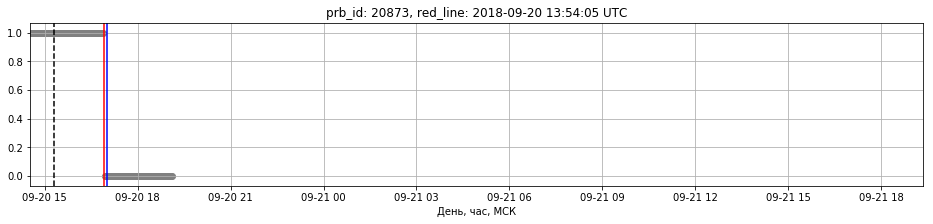

prb_id: 27858


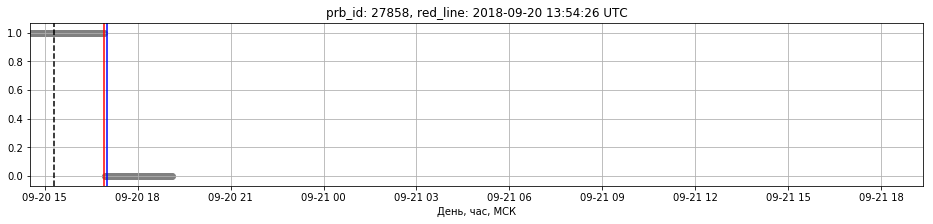

prb_id: 401


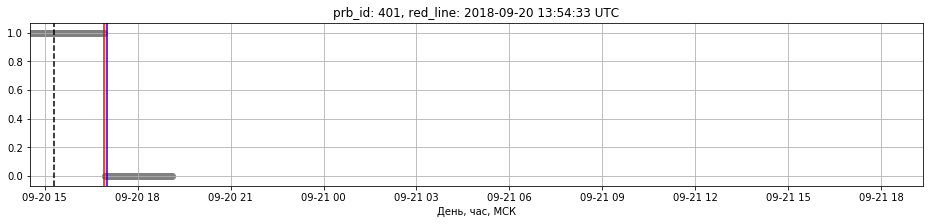

prb_id: 35631


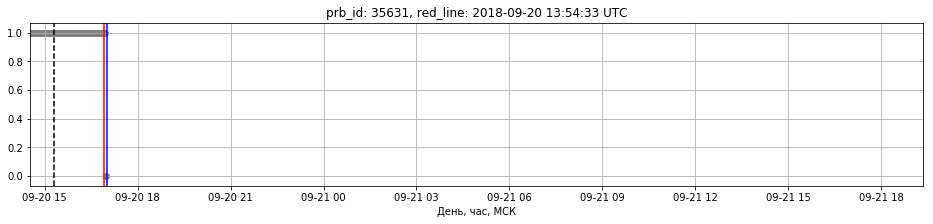

prb_id: 10059


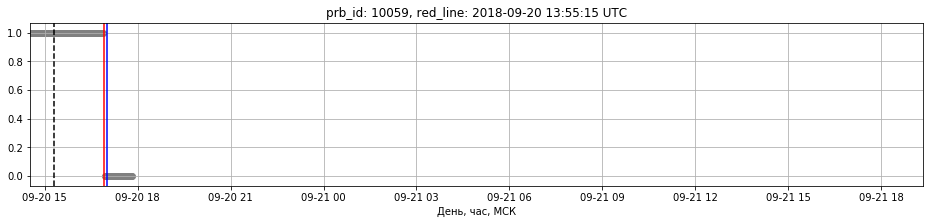

prb_id: 14011


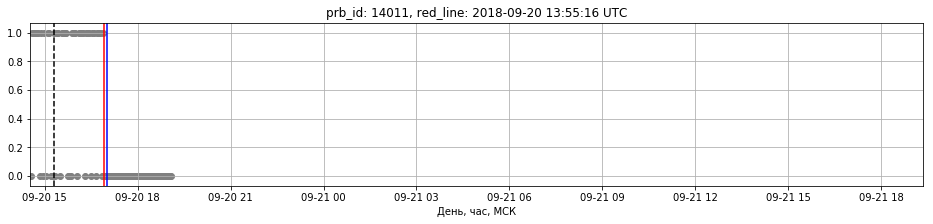

prb_id: 20749


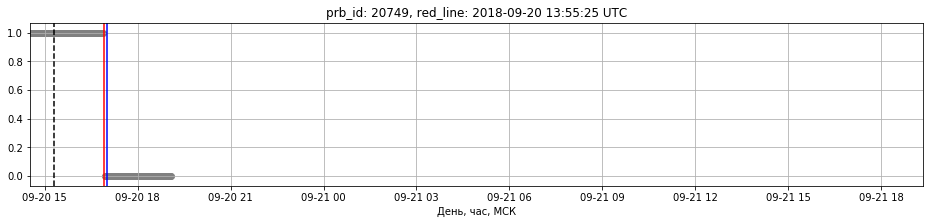

prb_id: 3815


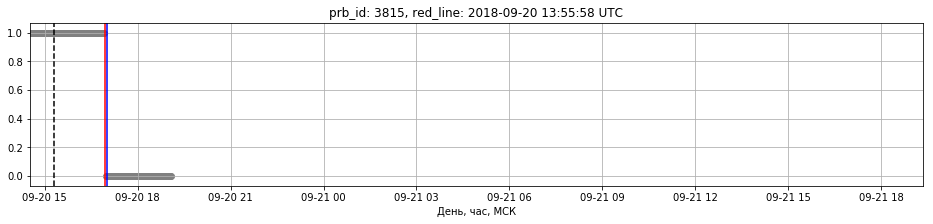

prb_id: 241


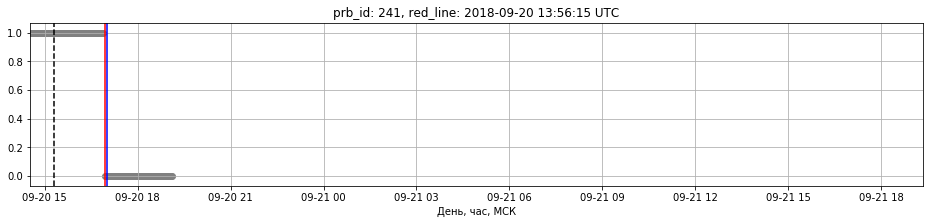

prb_id: 23973


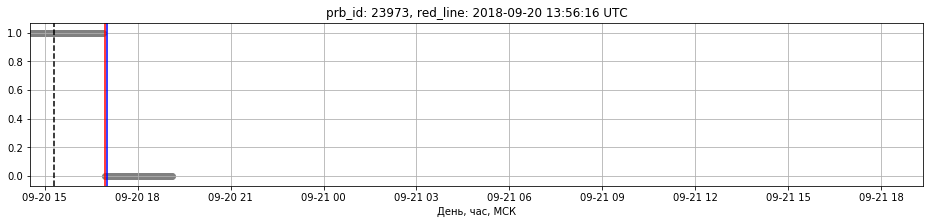

prb_id: 3696


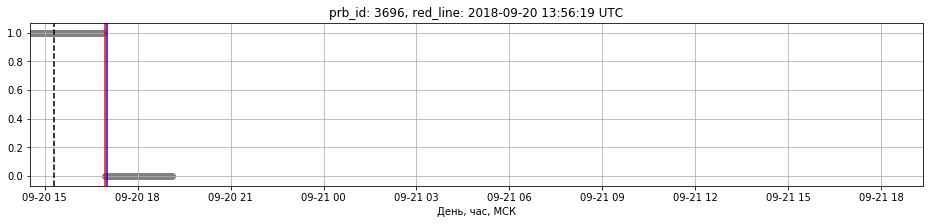

prb_id: 11098


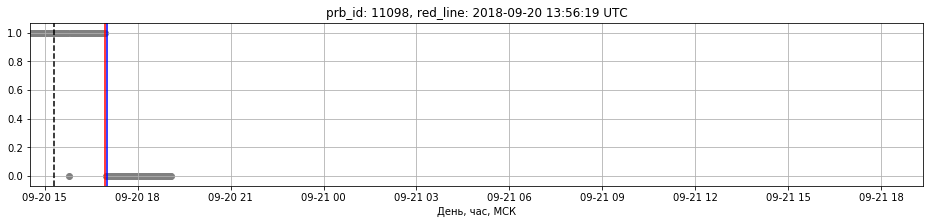

prb_id: 11429


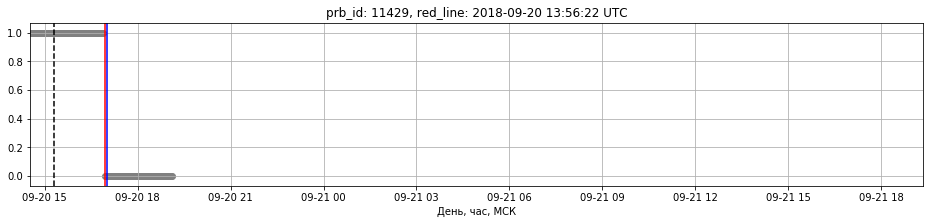

prb_id: 3854


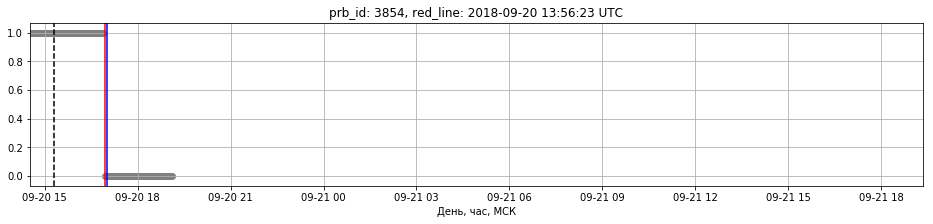

prb_id: 21451


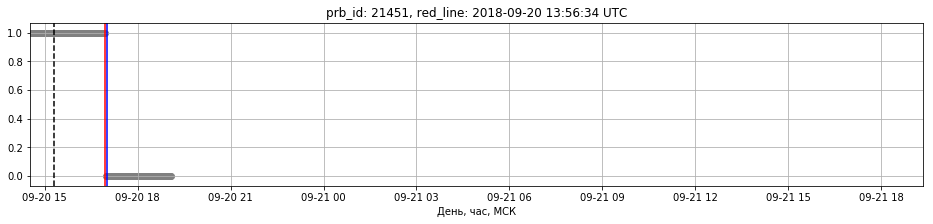

prb_id: 17744


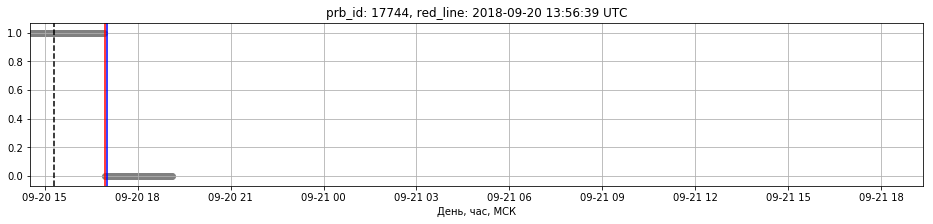

prb_id: 1341


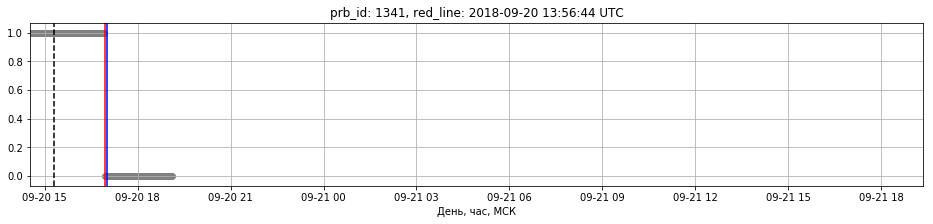

prb_id: 11994


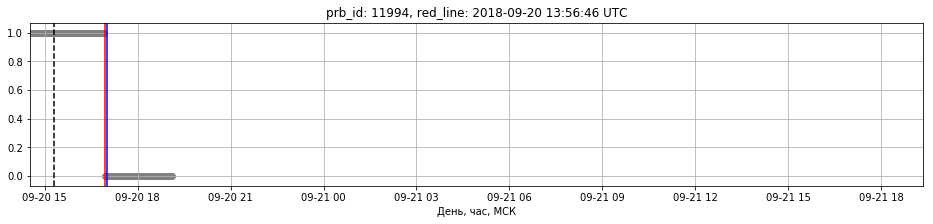

prb_id: 30741


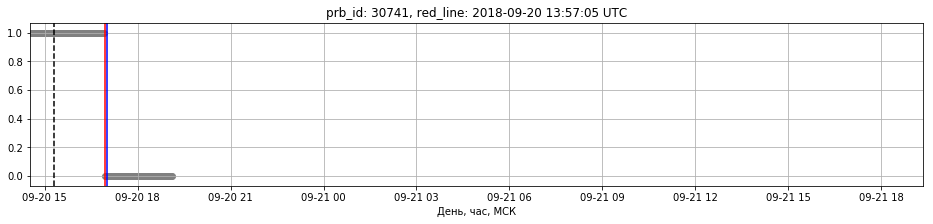

prb_id: 3868


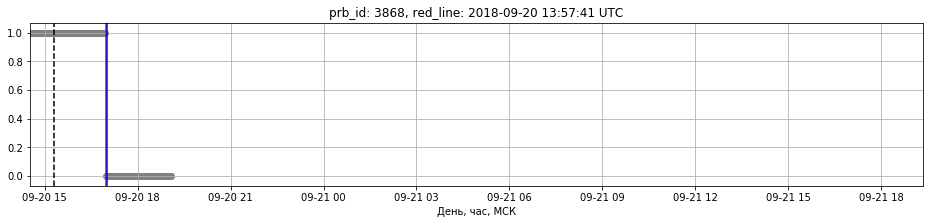

prb_id: 3959


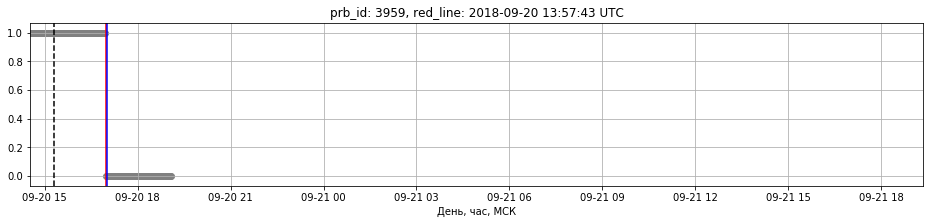

prb_id: 28137


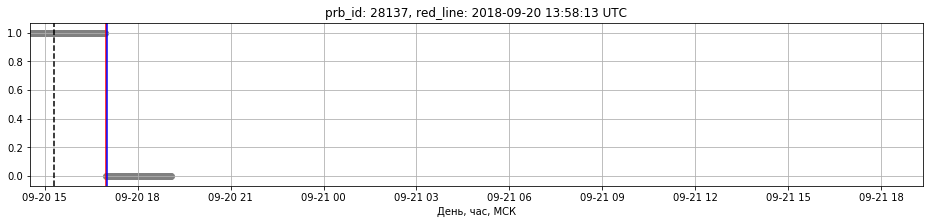

prb_id: 11501


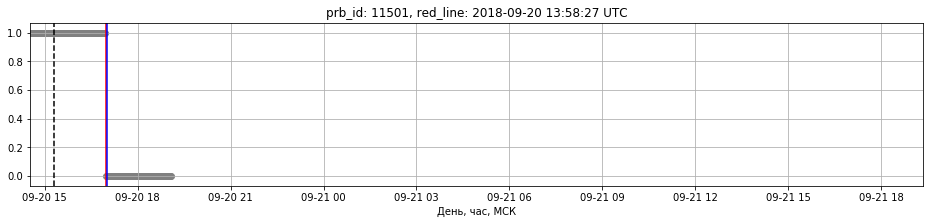

prb_id: 26190


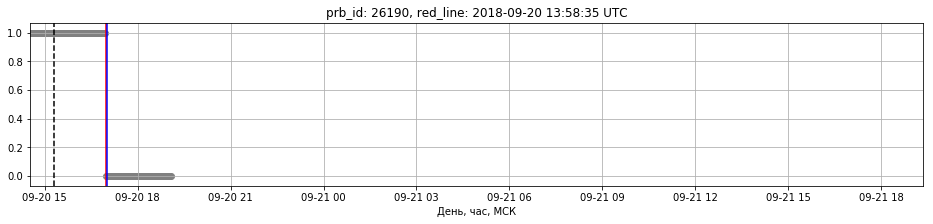

prb_id: 1227


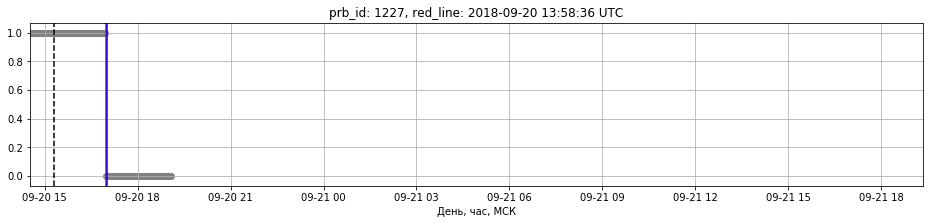

prb_id: 3780


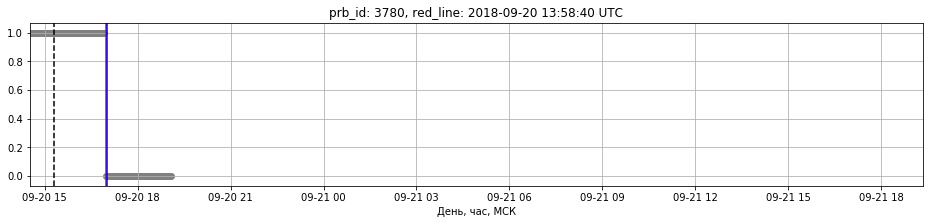

prb_id: 27180


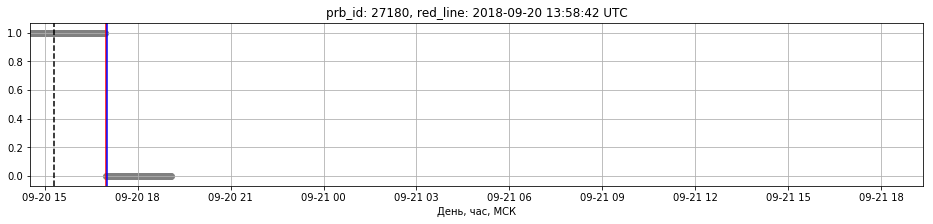

prb_id: 15121


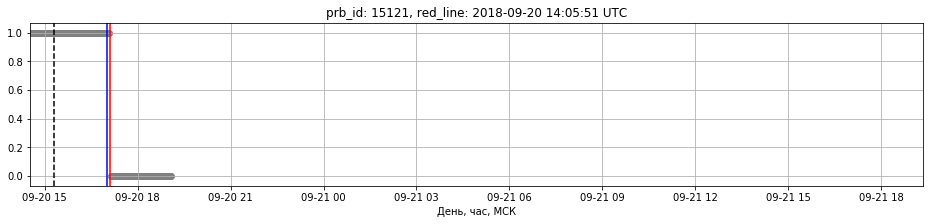

prb_id: 15523


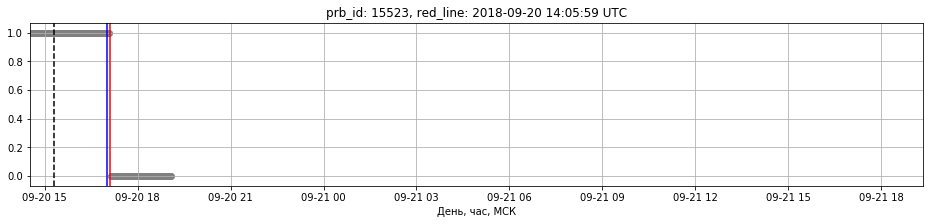

prb_id: 26580


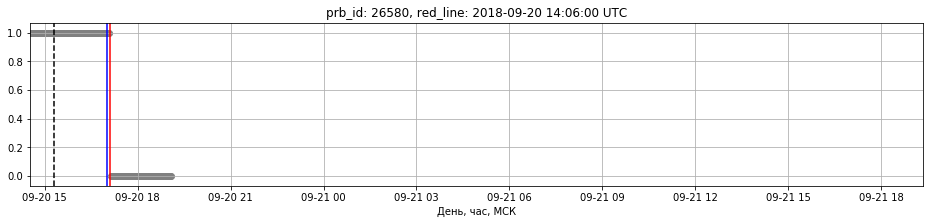

prb_id: 10865


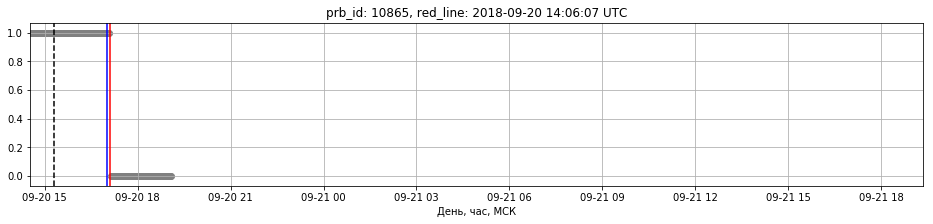

prb_id: 12896


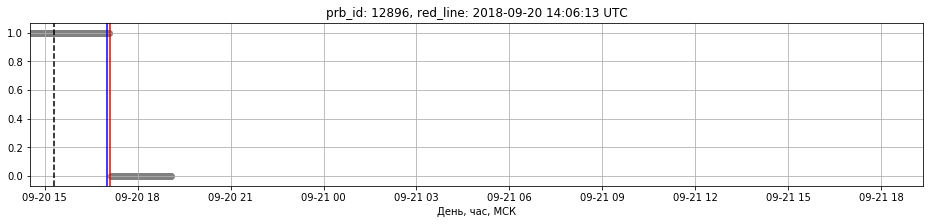

prb_id: 10822


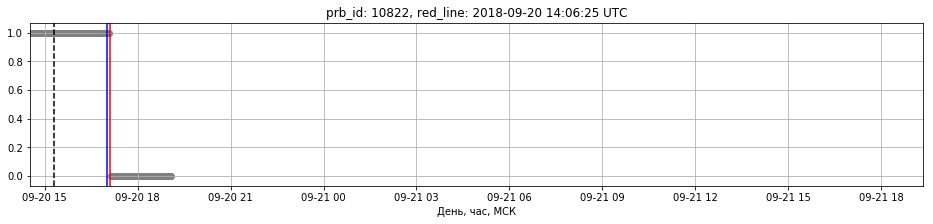

prb_id: 3768


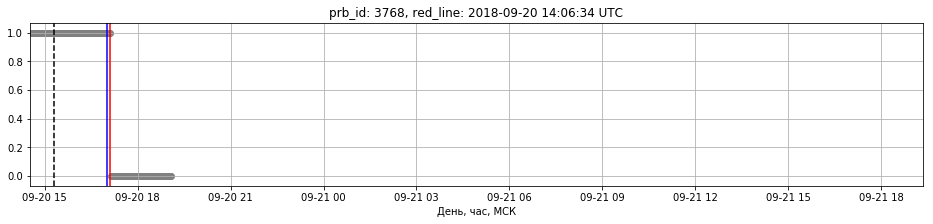

prb_id: 12890


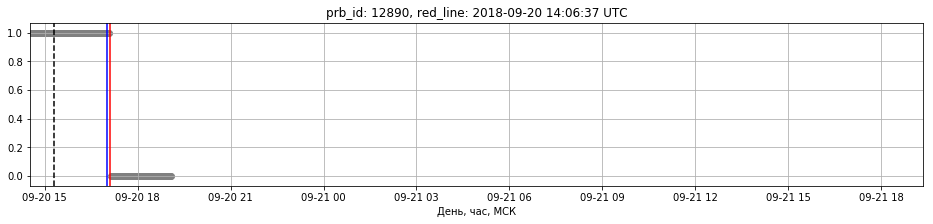

prb_id: 3834


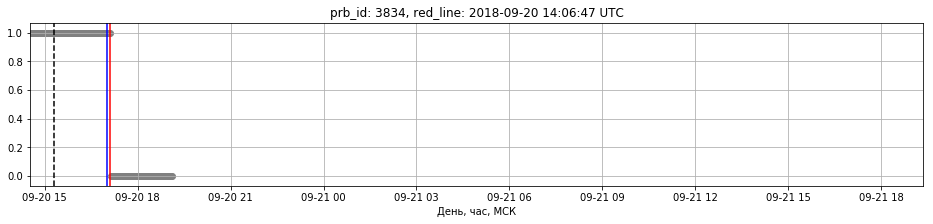

prb_id: 14680


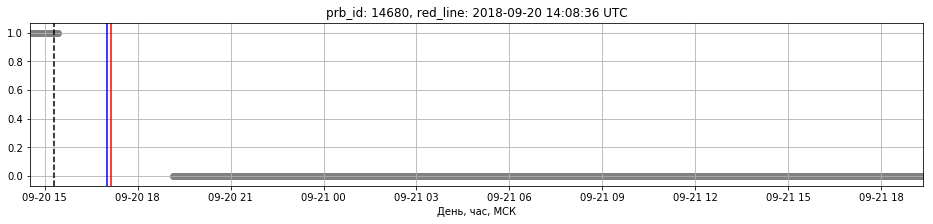

prb_id: 34179


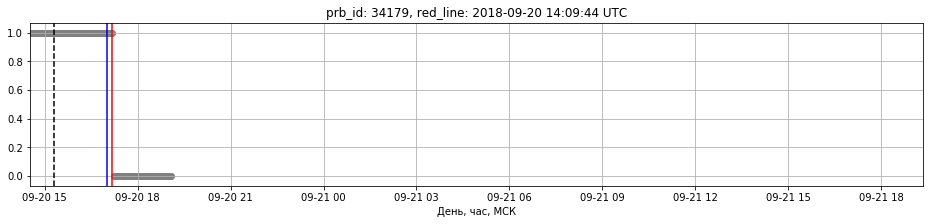

prb_id: 32510


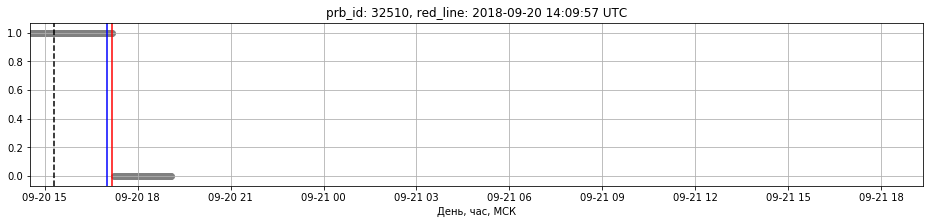

prb_id: 22777


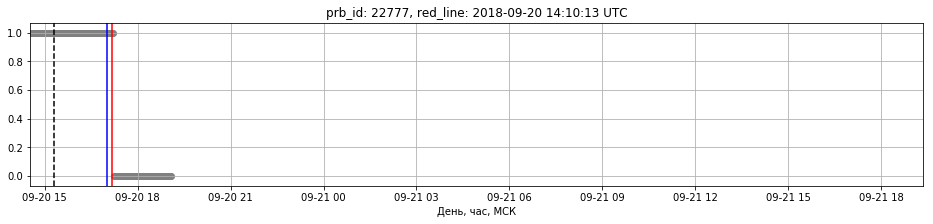

prb_id: 3714


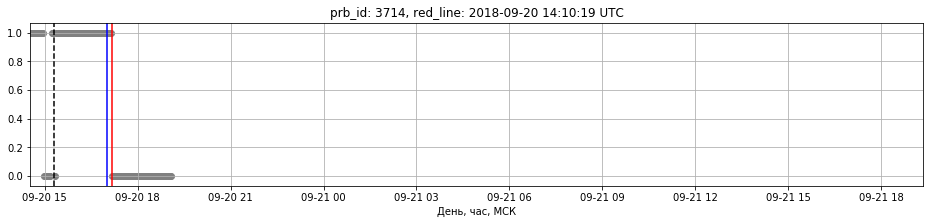

prb_id: 2274


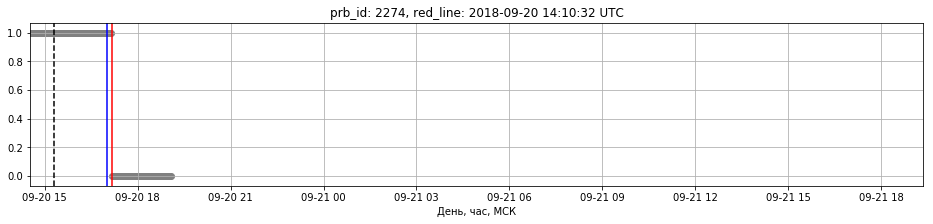

prb_id: 18691


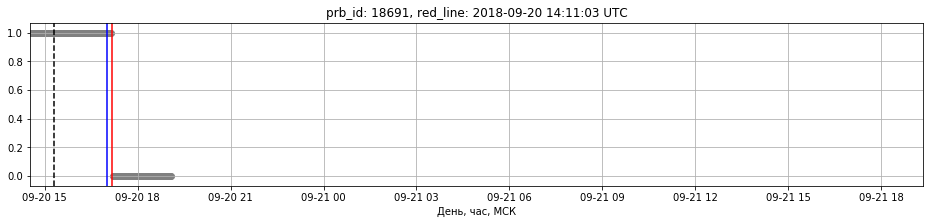

prb_id: 2590


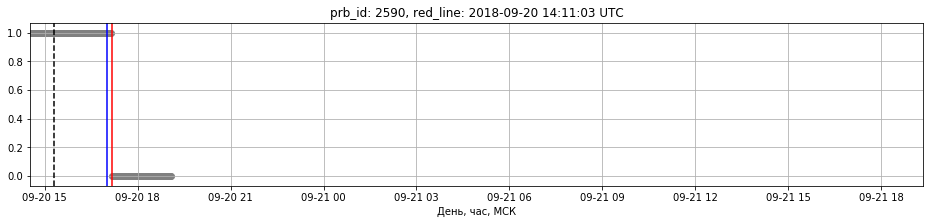

prb_id: 30097


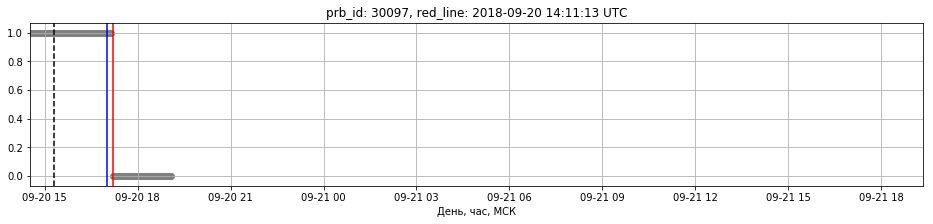

prb_id: 21662


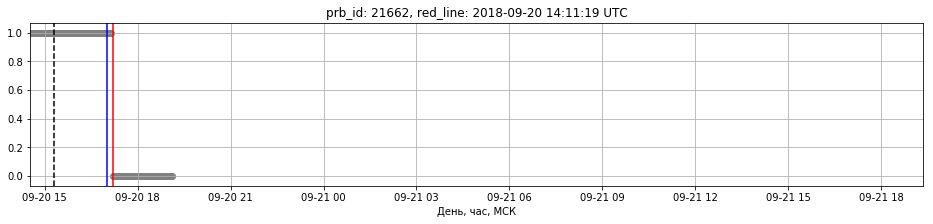

prb_id: 35632


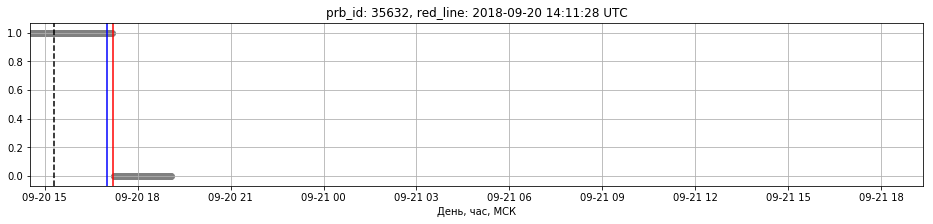

prb_id: 11473


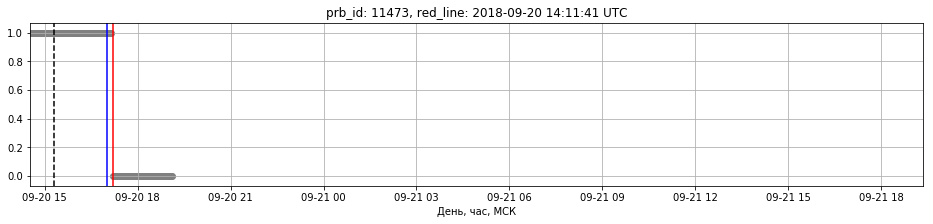

prb_id: 11902


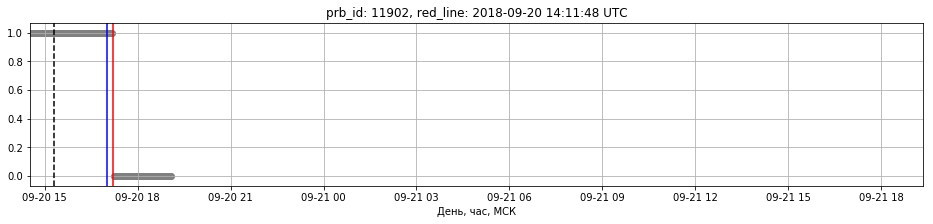

prb_id: 11437


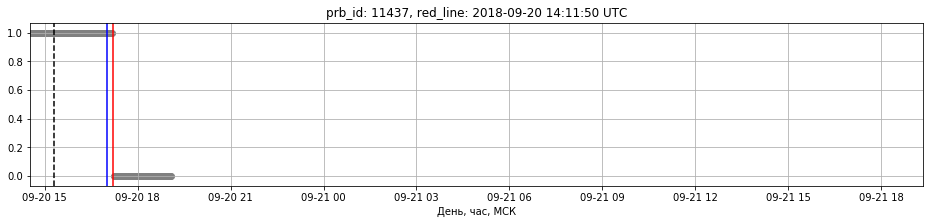

prb_id: 31479


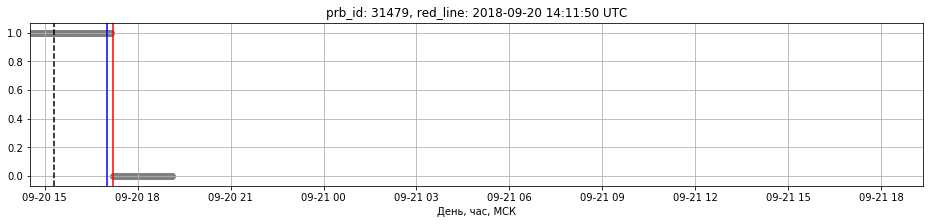

prb_id: 18906


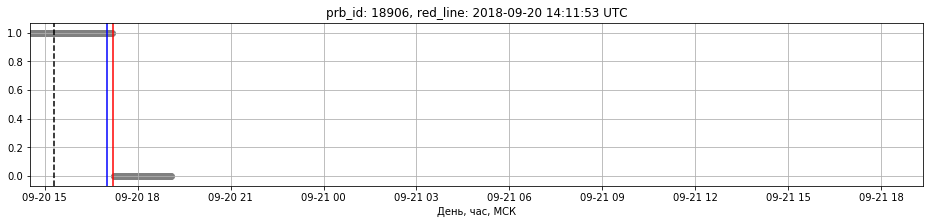

prb_id: 30988


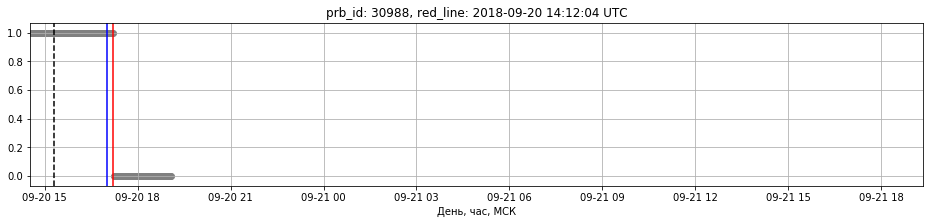

prb_id: 14230


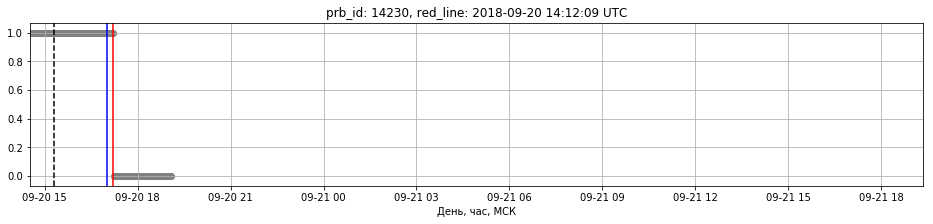

prb_id: 22643


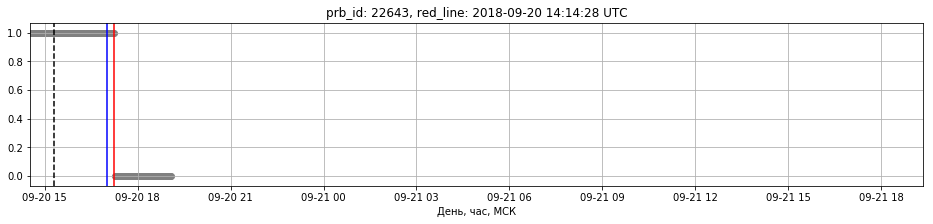

prb_id: 31198


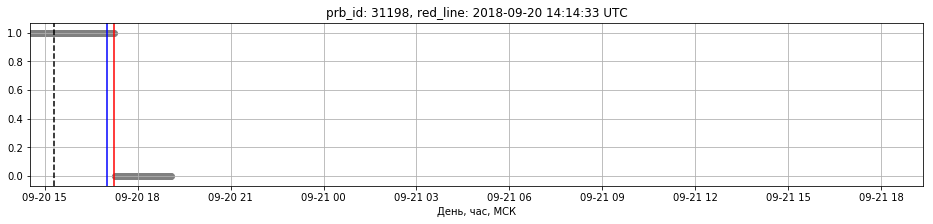

prb_id: 28161


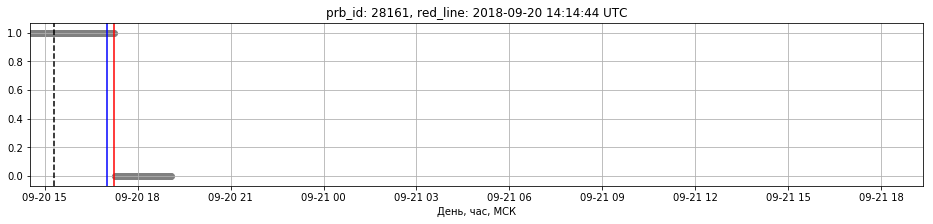

prb_id: 19878


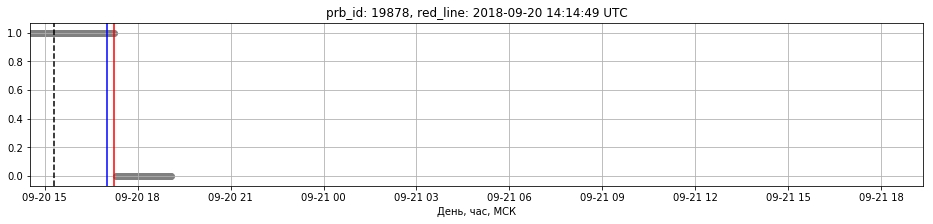

prb_id: 26656


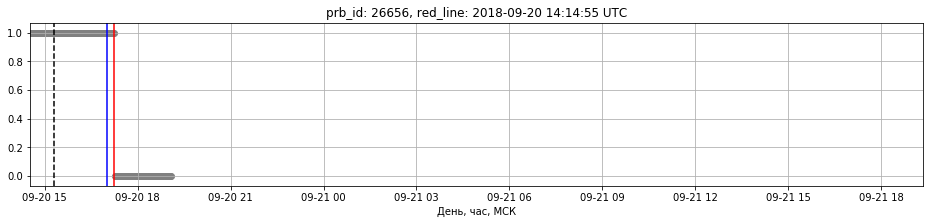

prb_id: 19803


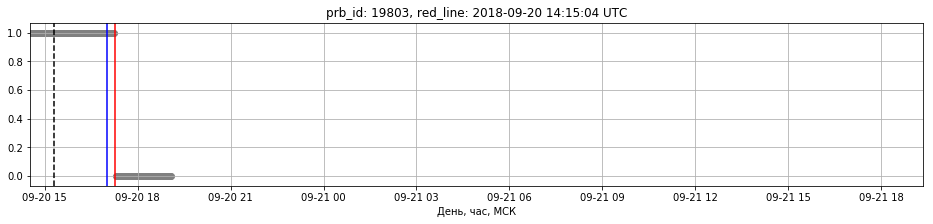

prb_id: 35271


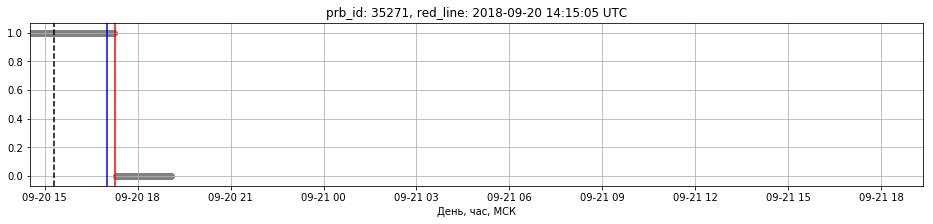

prb_id: 4440


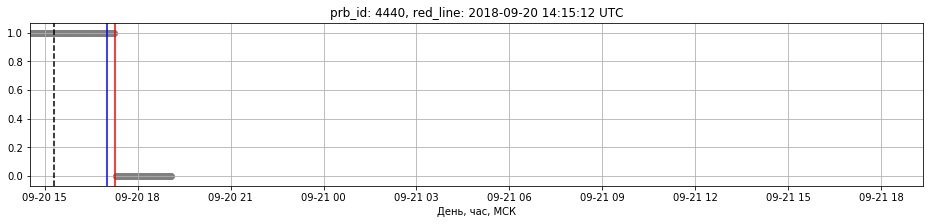

prb_id: 11487


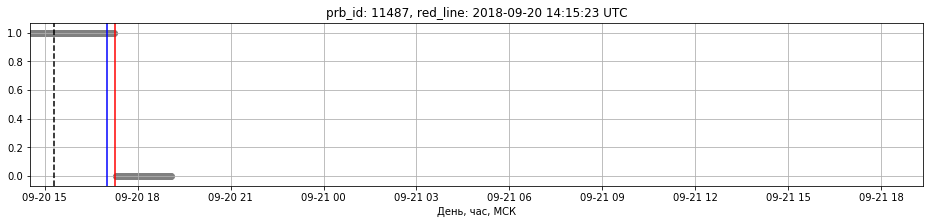

prb_id: 884


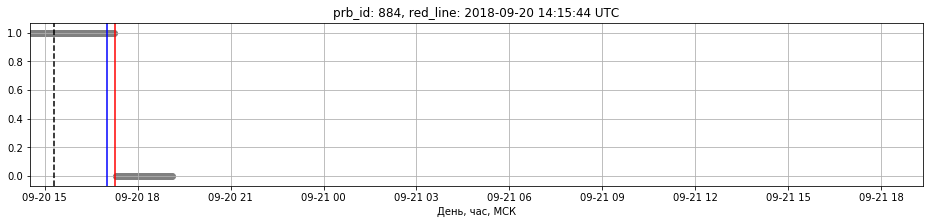

prb_id: 652


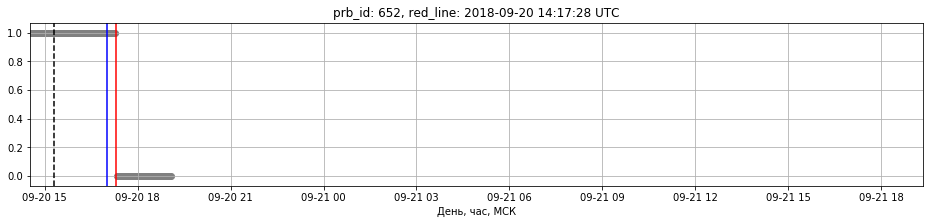

prb_id: 13321


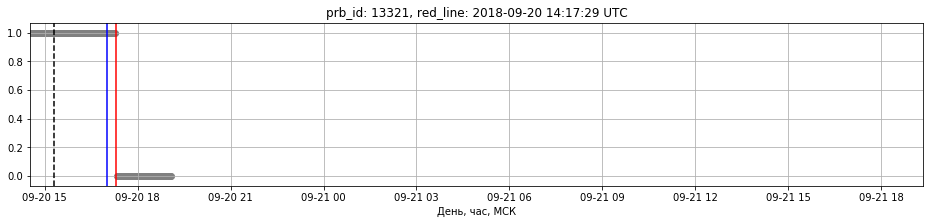

prb_id: 3892


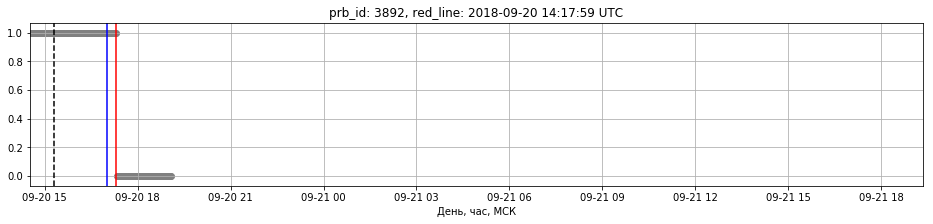

prb_id: 25354


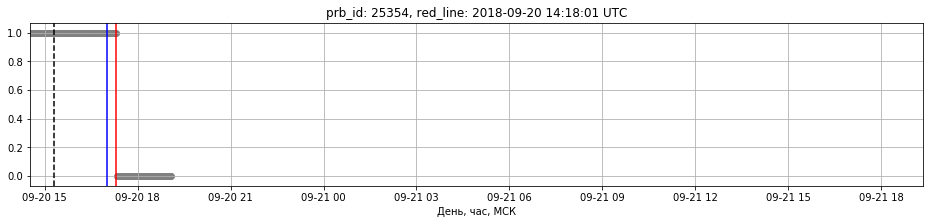

prb_id: 3613


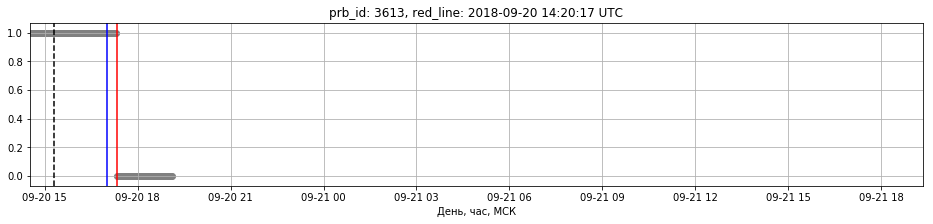

prb_id: 4352


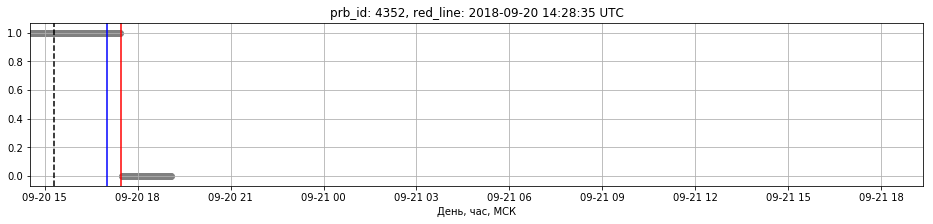

prb_id: 21035


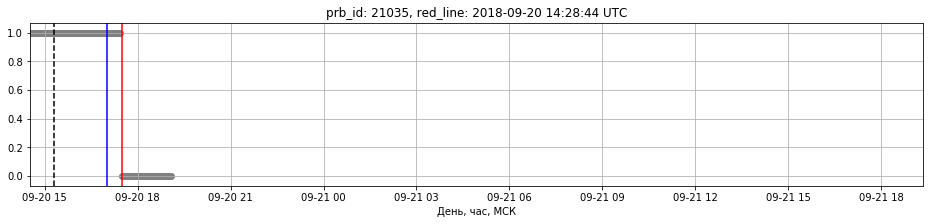

prb_id: 310


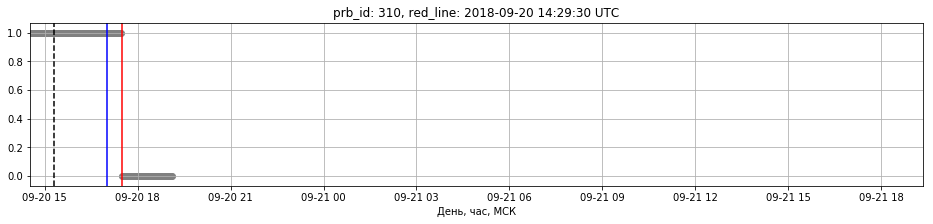

prb_id: 3804


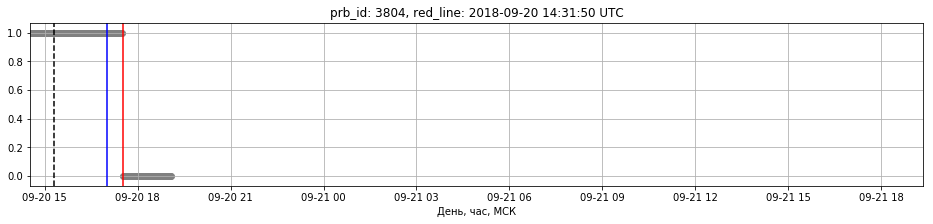

prb_id: 35318


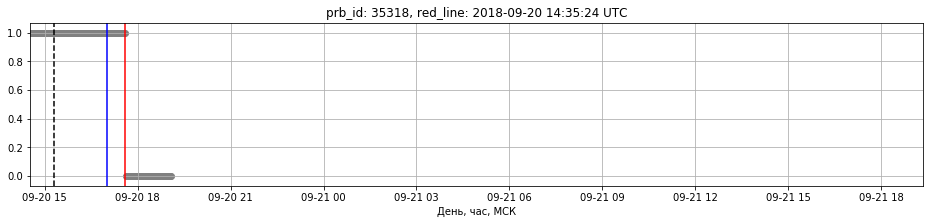

prb_id: 35437


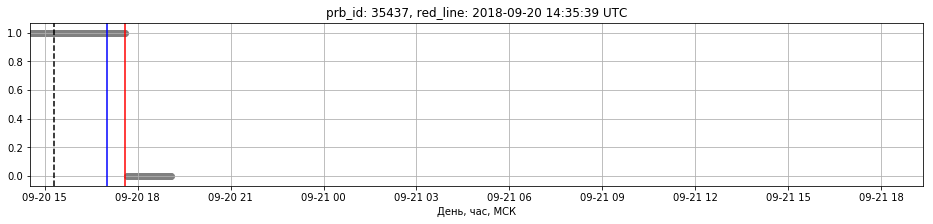

prb_id: 23328


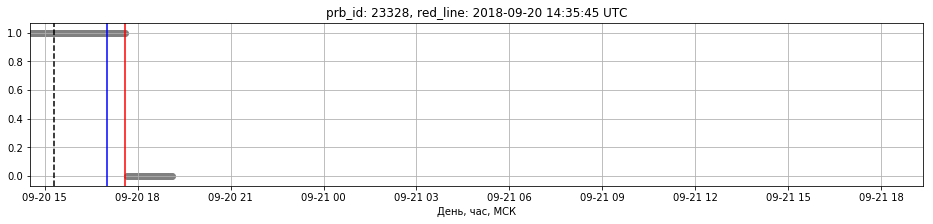

prb_id: 20984


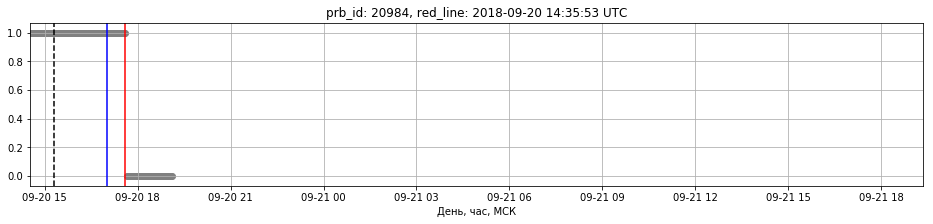

prb_id: 2559


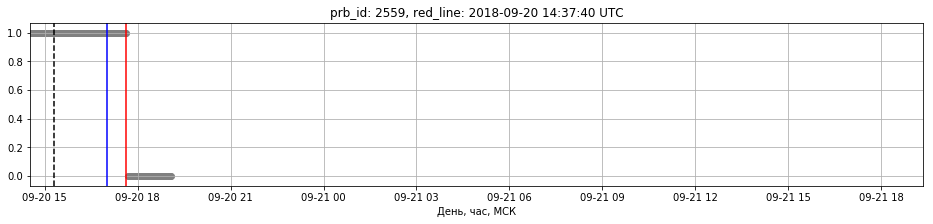

prb_id: 15209


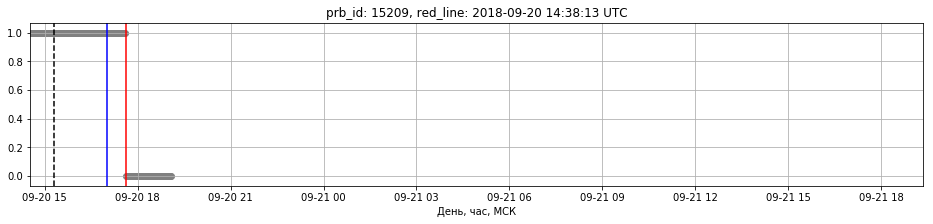

prb_id: 11116


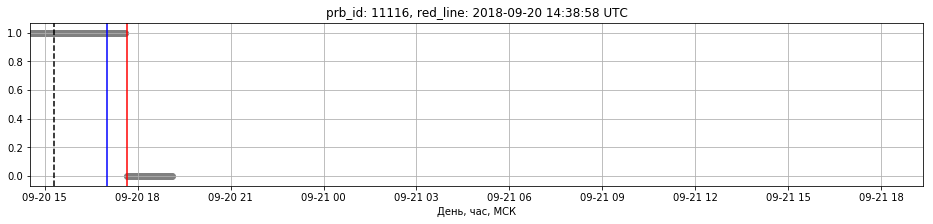

prb_id: 11046


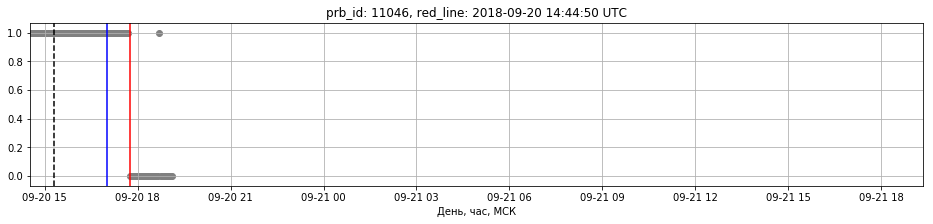

prb_id: 17703


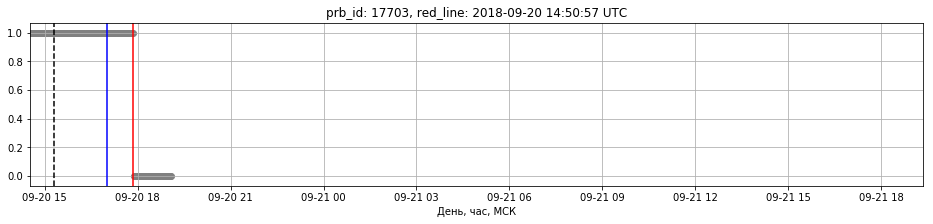

prb_id: 34154


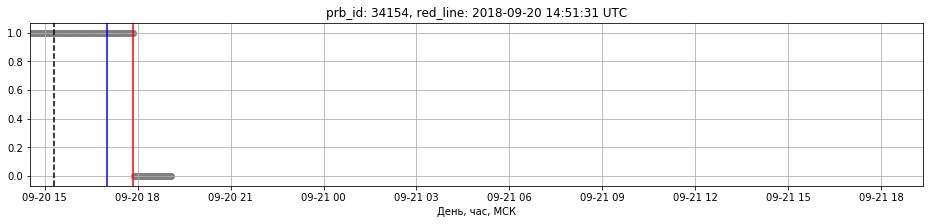

prb_id: 11361


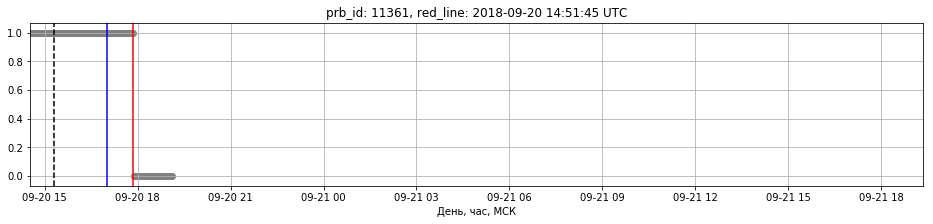

prb_id: 33182


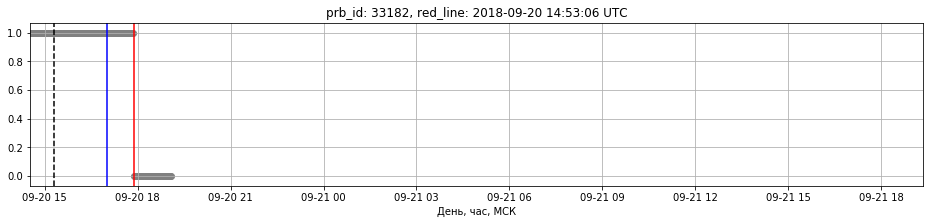

prb_id: 11344


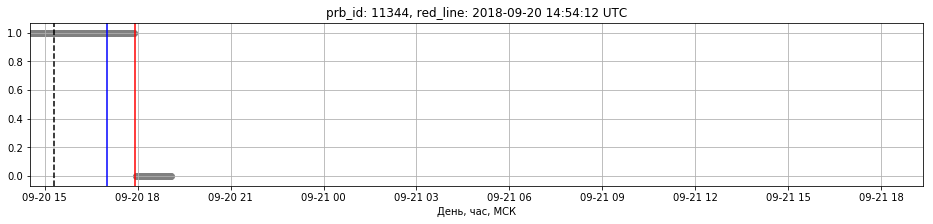

prb_id: 28662


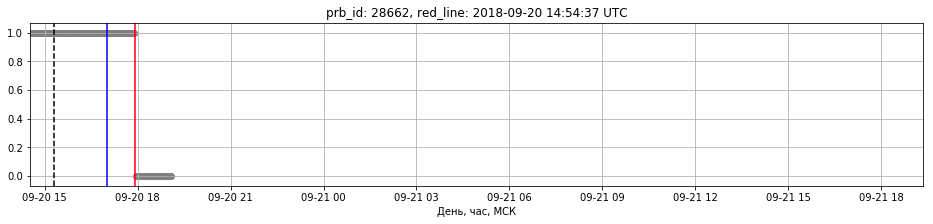

prb_id: 28228


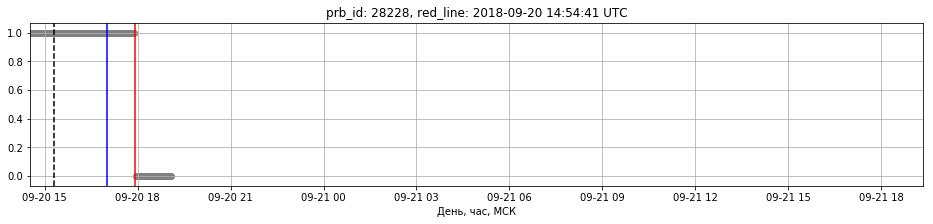

prb_id: 17706


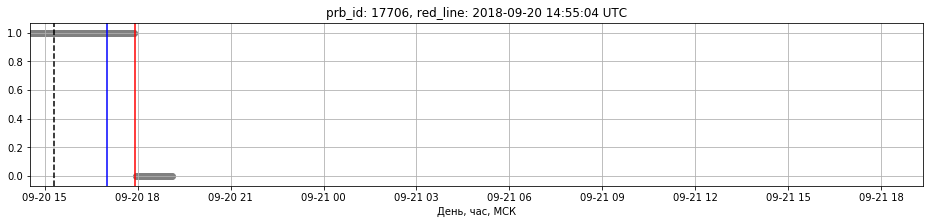

prb_id: 4496


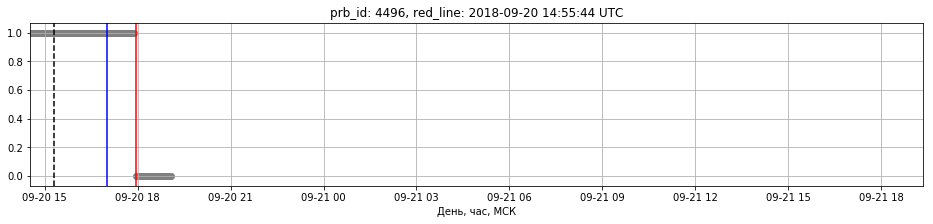

prb_id: 11423


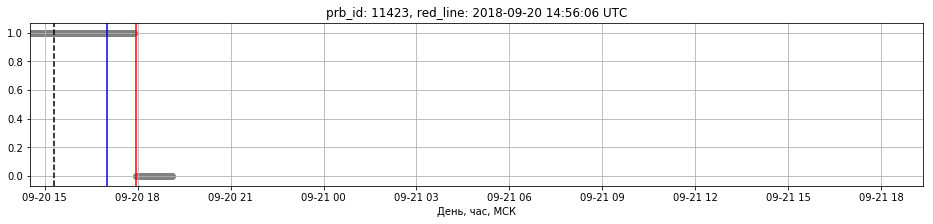

prb_id: 4358


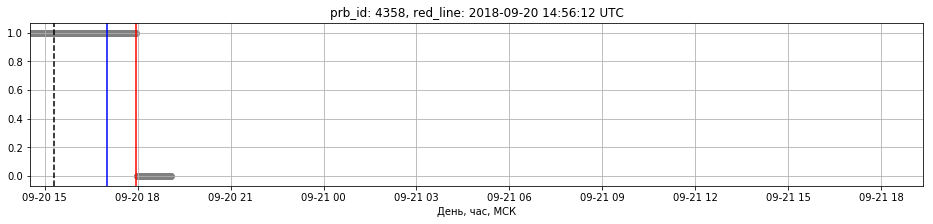

prb_id: 11426


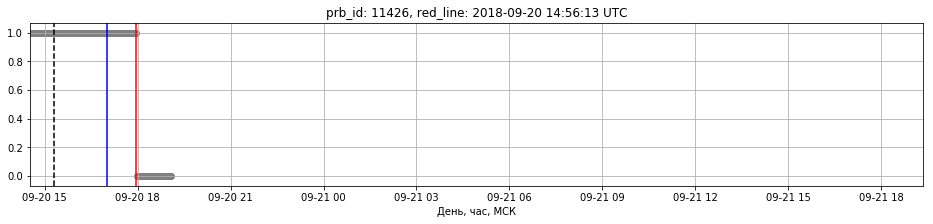

prb_id: 28335


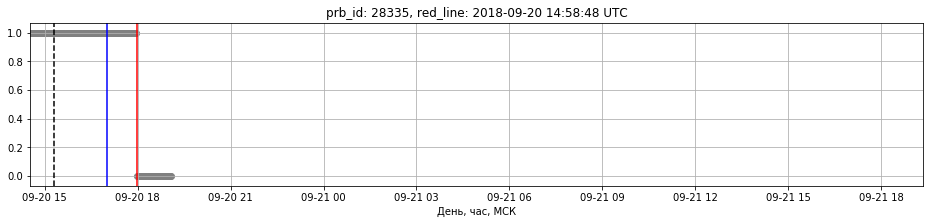

prb_id: 3880


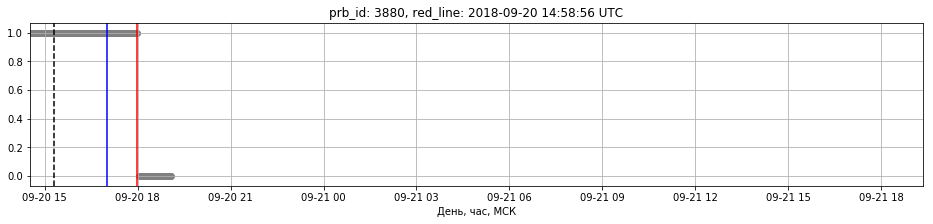

prb_id: 25203


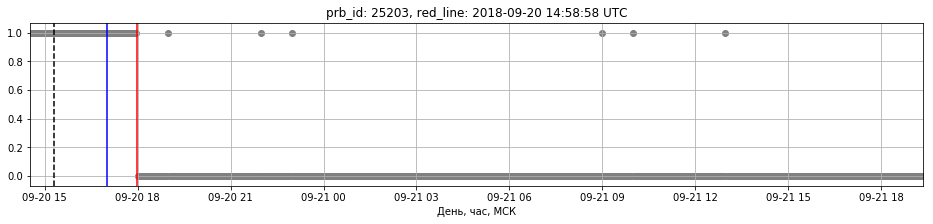

prb_id: 3553


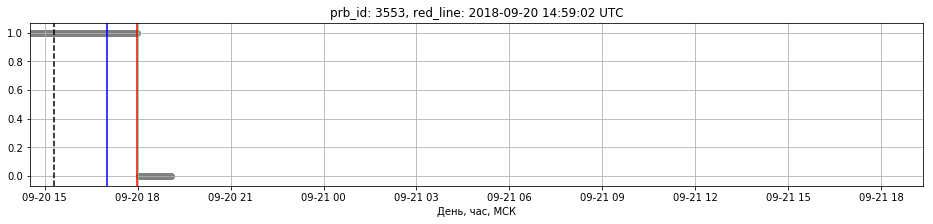

prb_id: 626


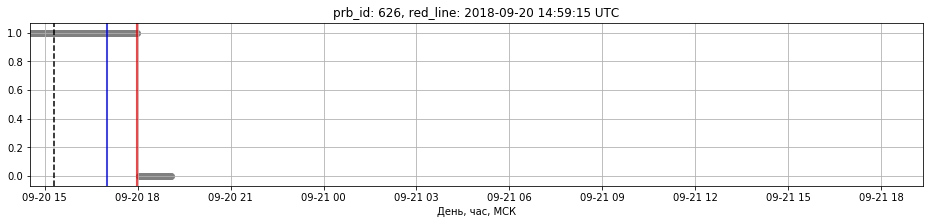

prb_id: 20001


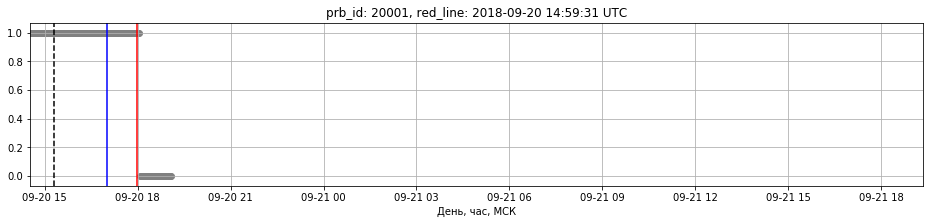

prb_id: 4453


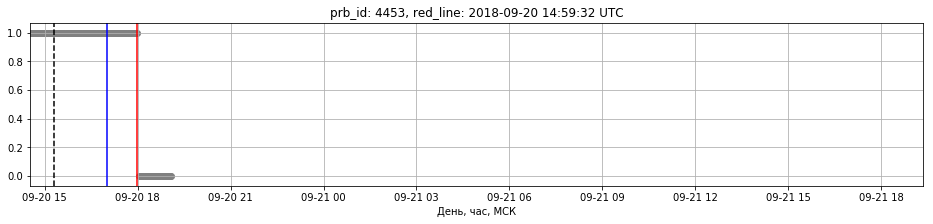

prb_id: 31213


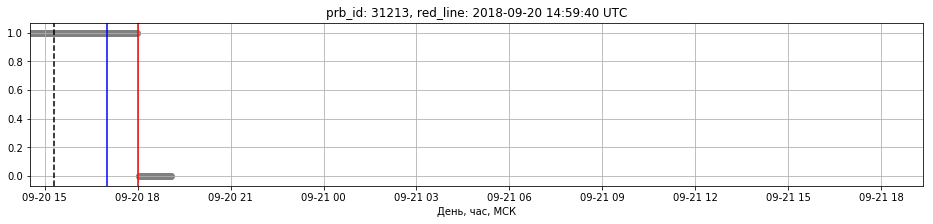

prb_id: 19166


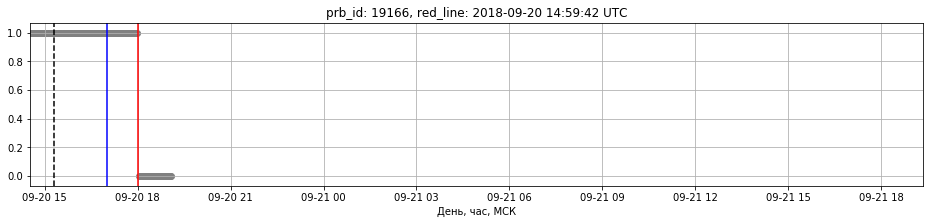

prb_id: 19146


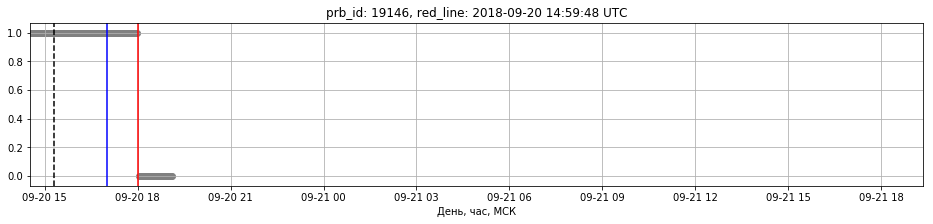

prb_id: 13251


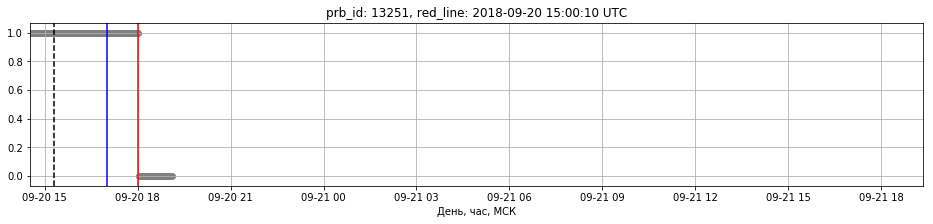

prb_id: 3888


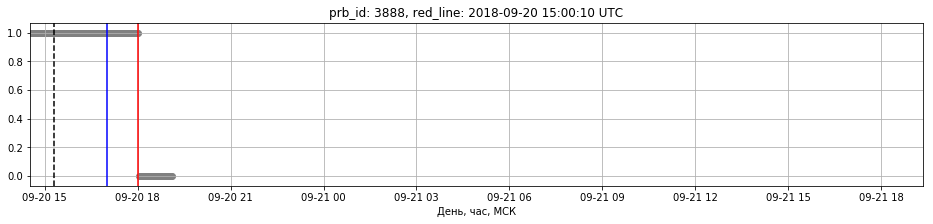

prb_id: 462


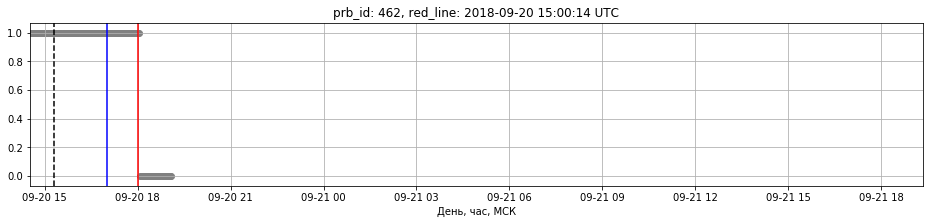

prb_id: 25003


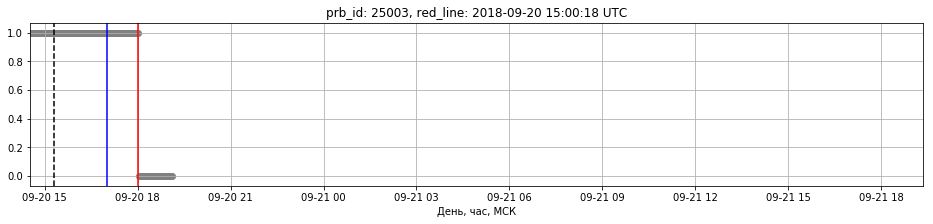

prb_id: 3782


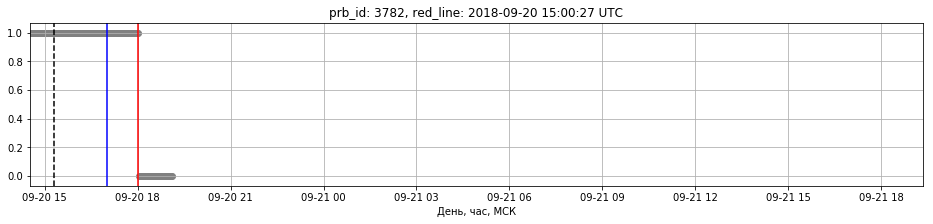

prb_id: 26538


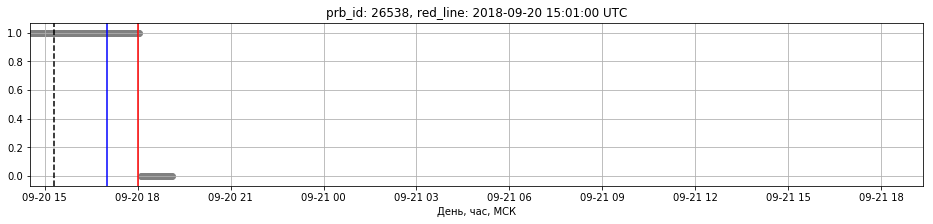

prb_id: 4383


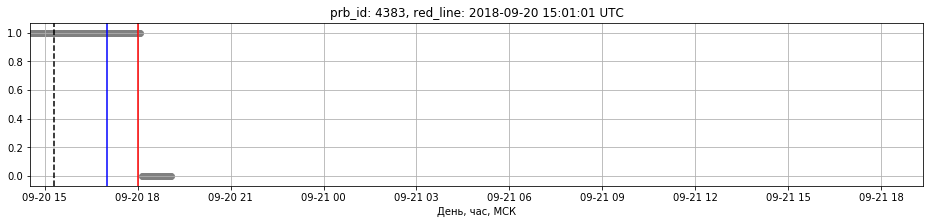

prb_id: 4854


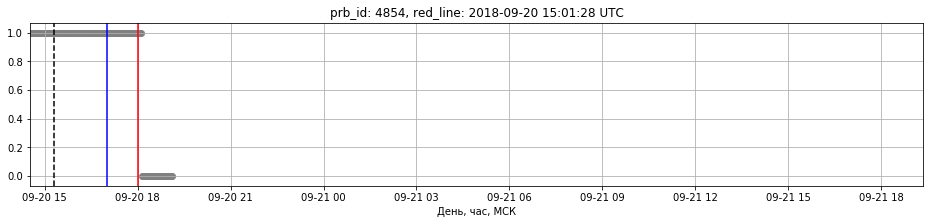

prb_id: 26966


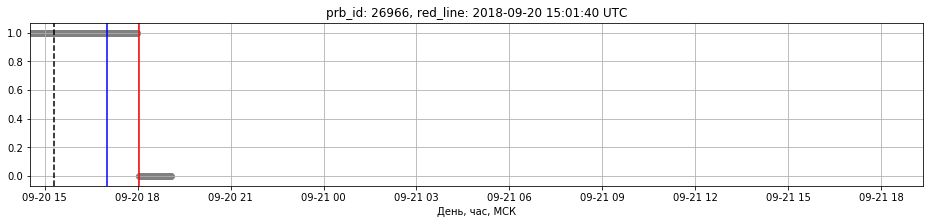

prb_id: 13910


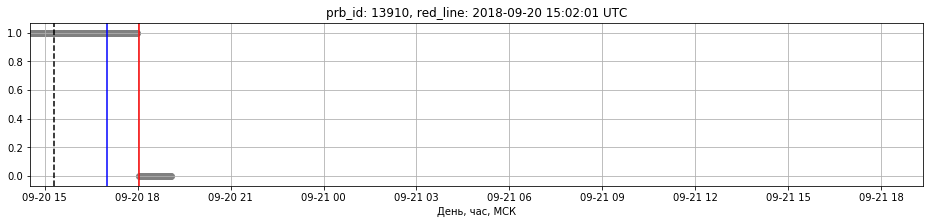

prb_id: 30569


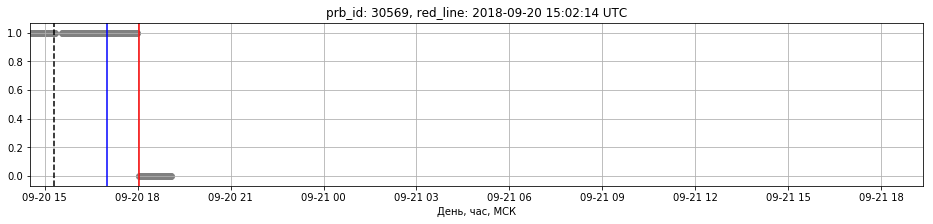

prb_id: 11992


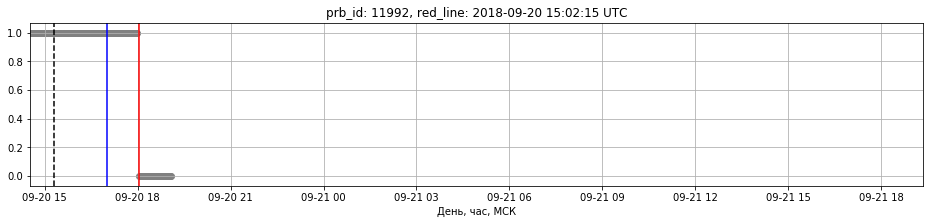

prb_id: 4204


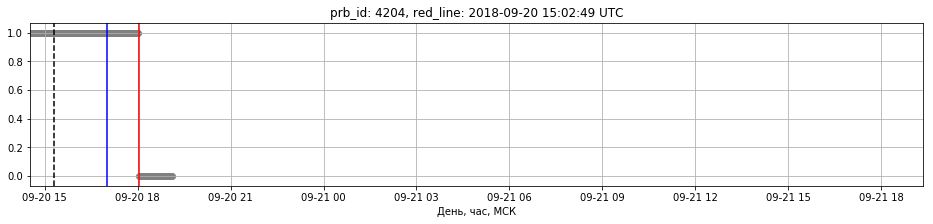

prb_id: 4123


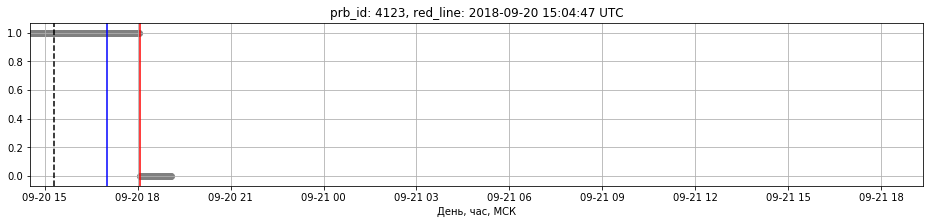

prb_id: 1316


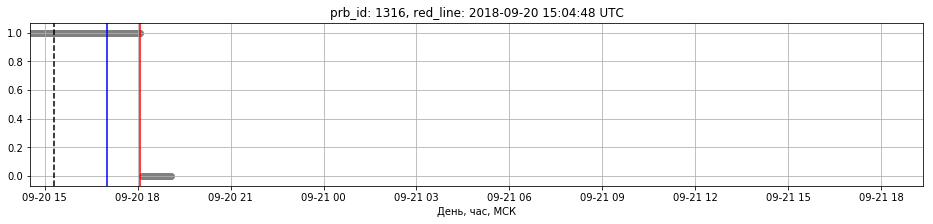

prb_id: 17781


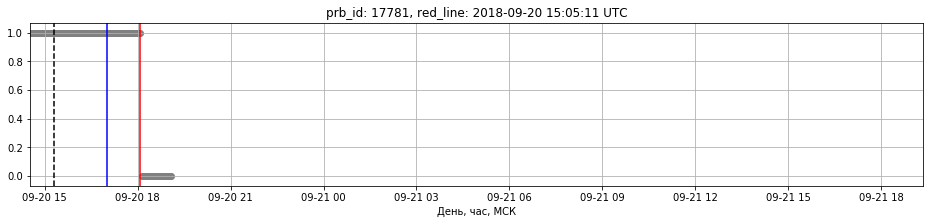

prb_id: 20223


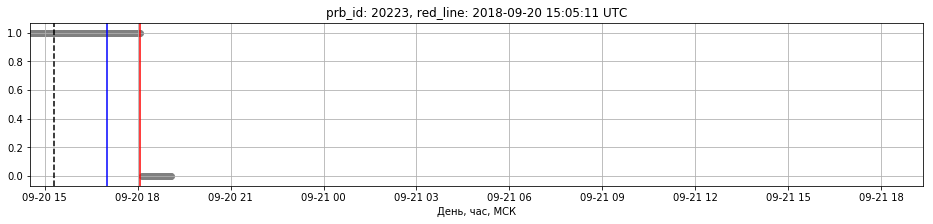

prb_id: 20955


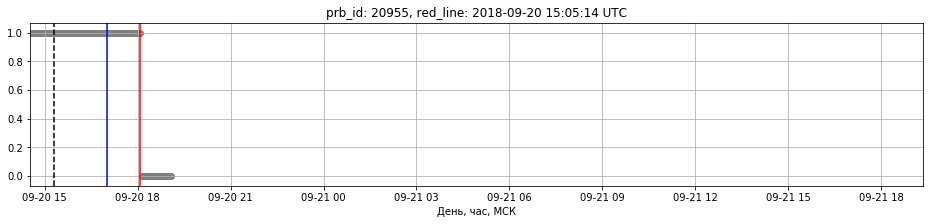

prb_id: 28036


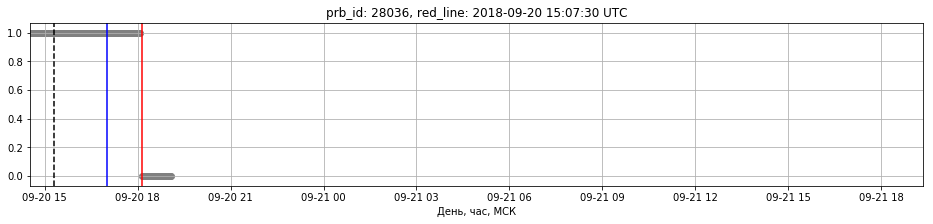

prb_id: 27016


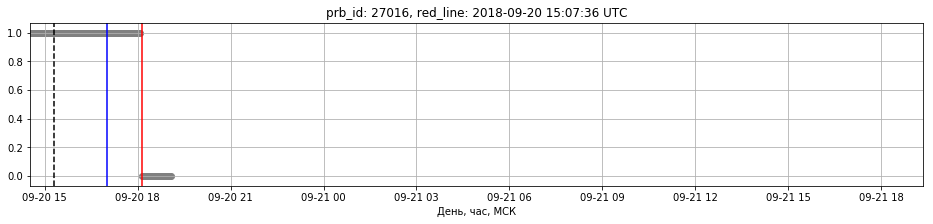

prb_id: 12873


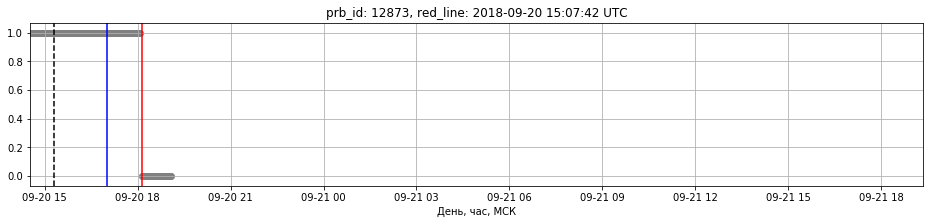

prb_id: 17708


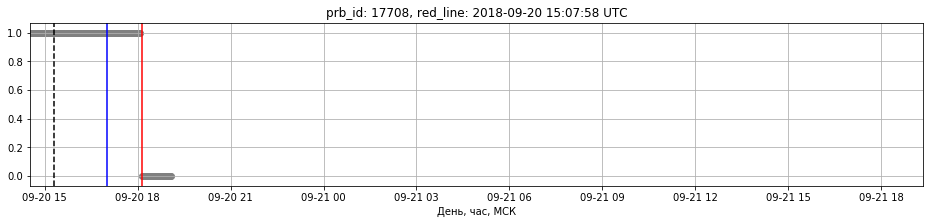

prb_id: 3879


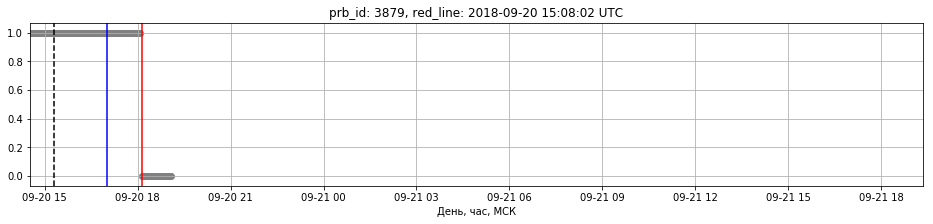

prb_id: 11716


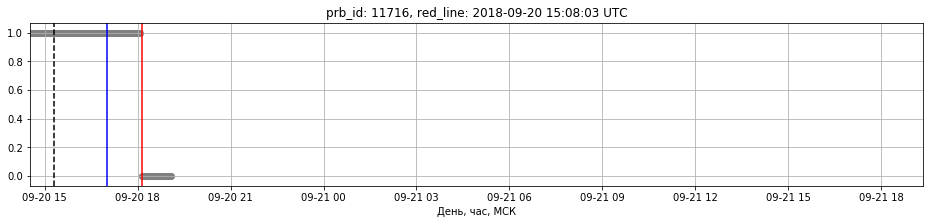

prb_id: 4862


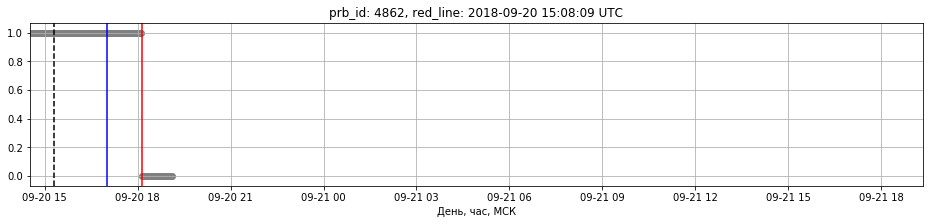

prb_id: 3763


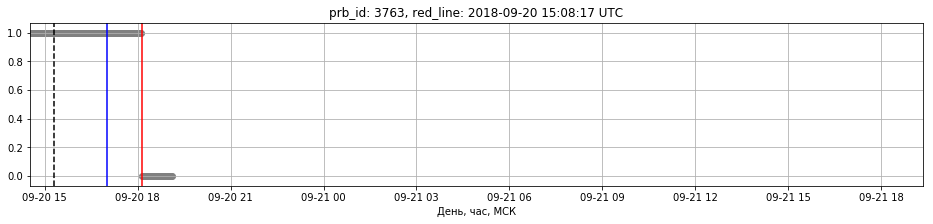

prb_id: 3869


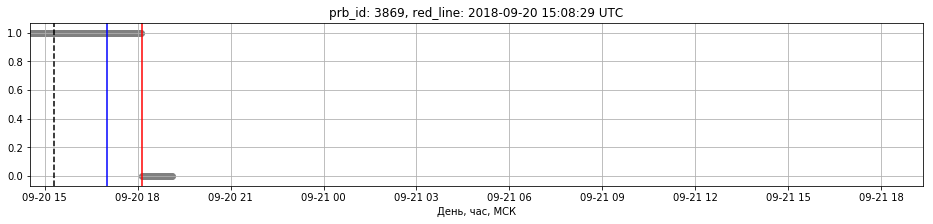

prb_id: 27383


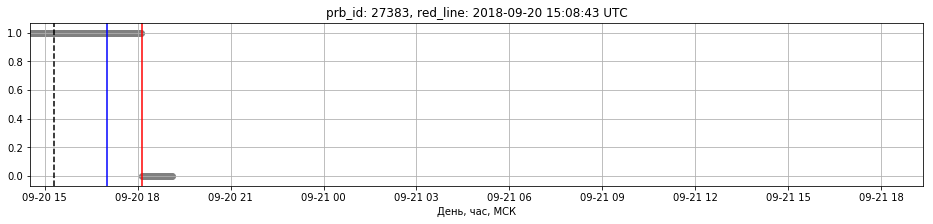

prb_id: 17619


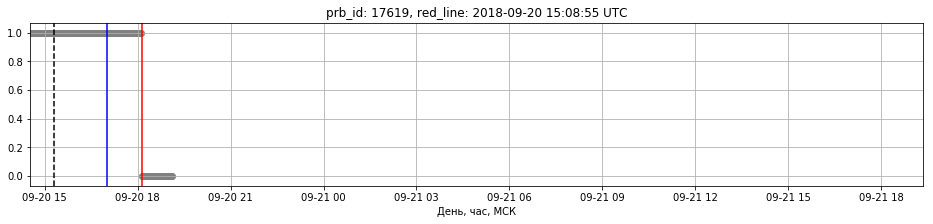

prb_id: 3867


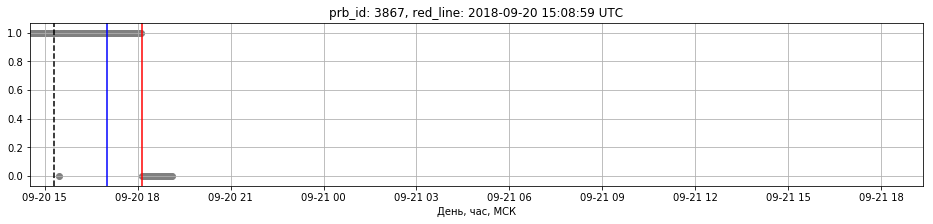

prb_id: 26666


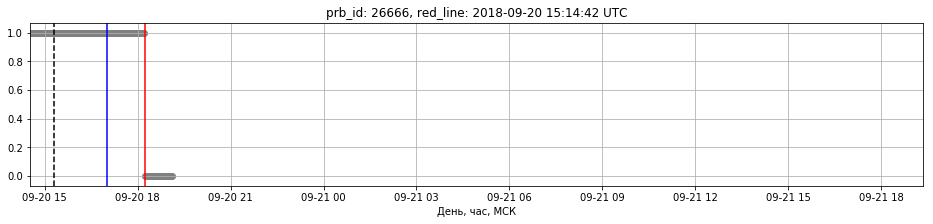

prb_id: 3828


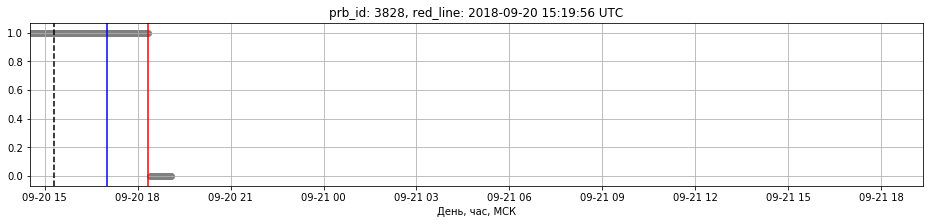

prb_id: 21062


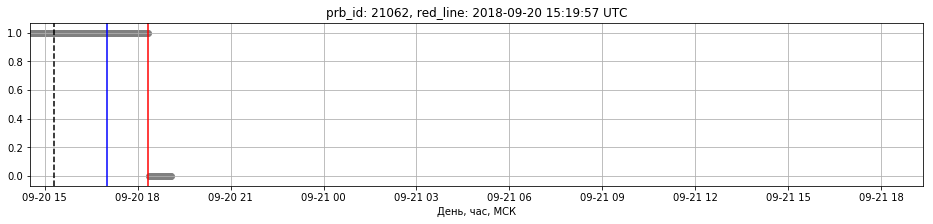

prb_id: 847


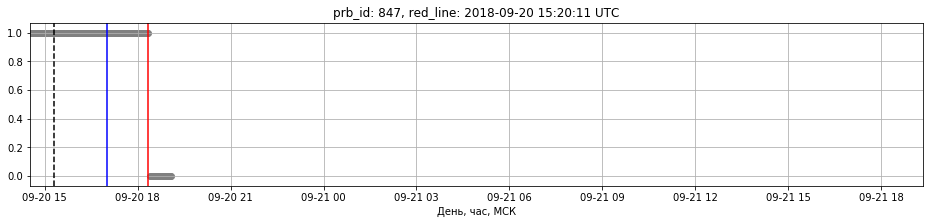

prb_id: 4042


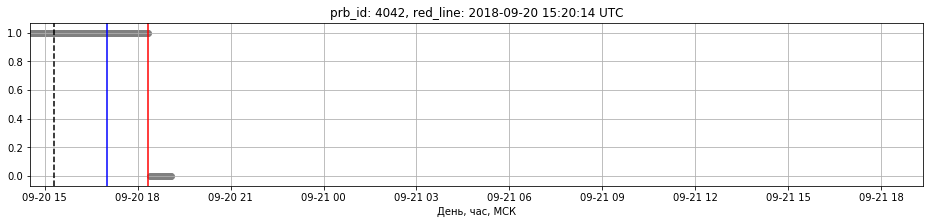

prb_id: 11038


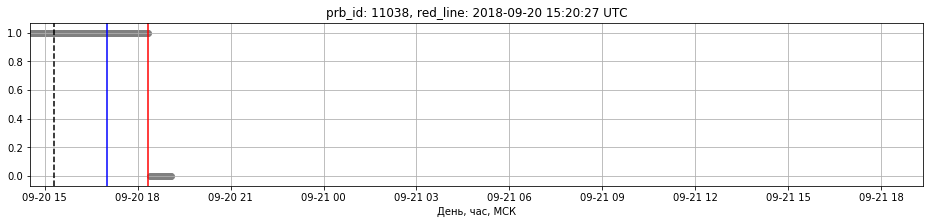

prb_id: 3946


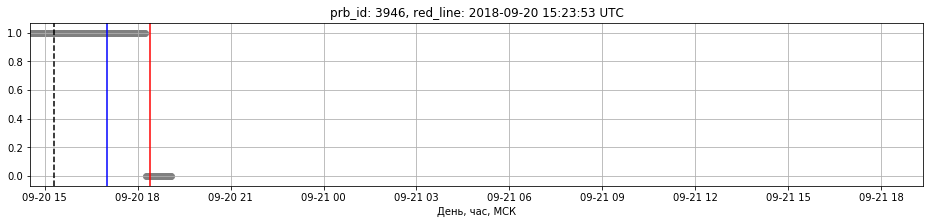

prb_id: 32988


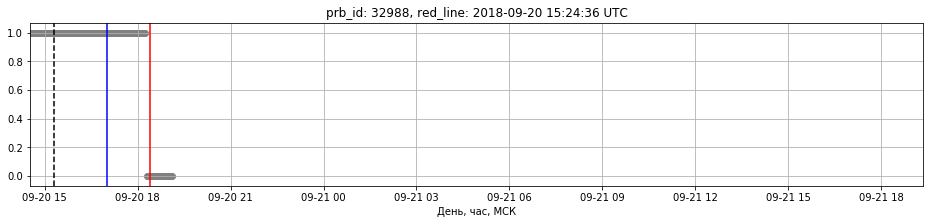

prb_id: 17285


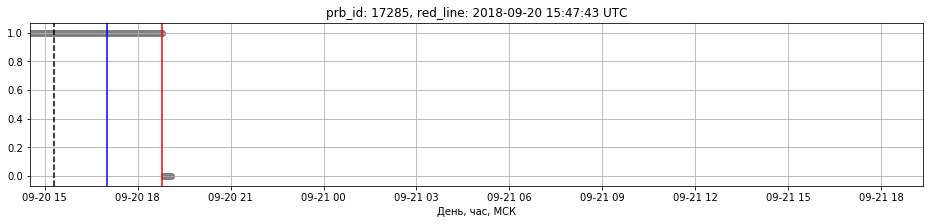

prb_id: 3841


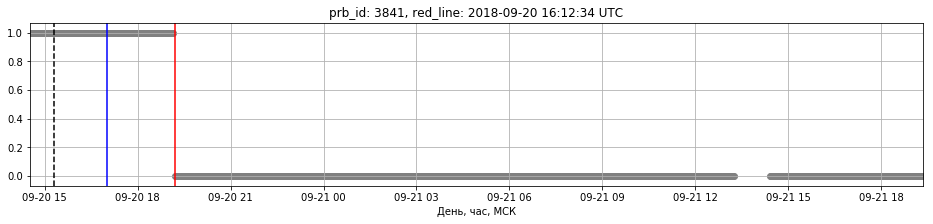

prb_id: 18806


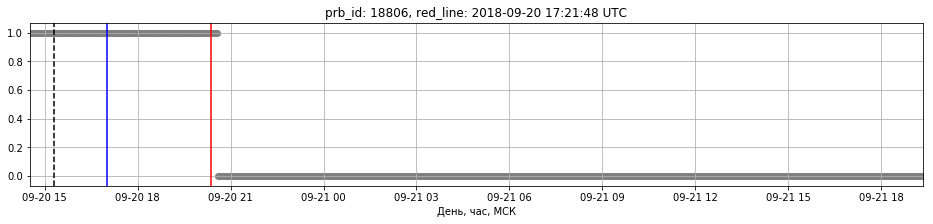

prb_id: 29176


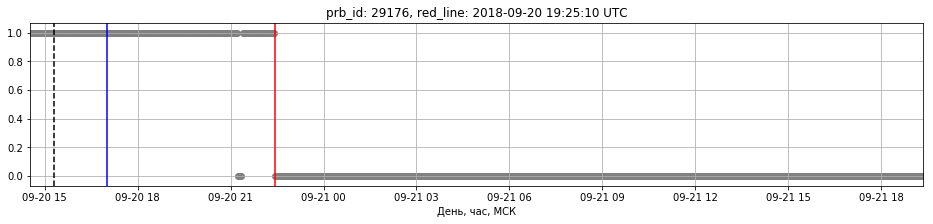

prb_id: 22038


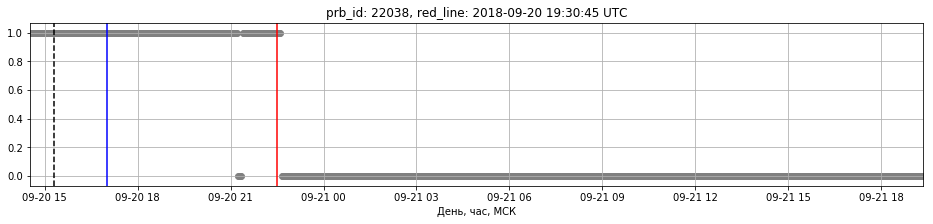

prb_id: 10262


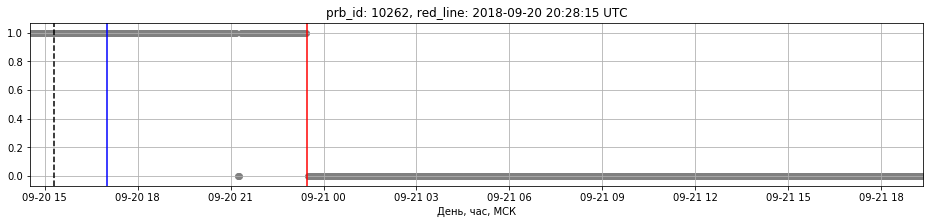

prb_id: 30817


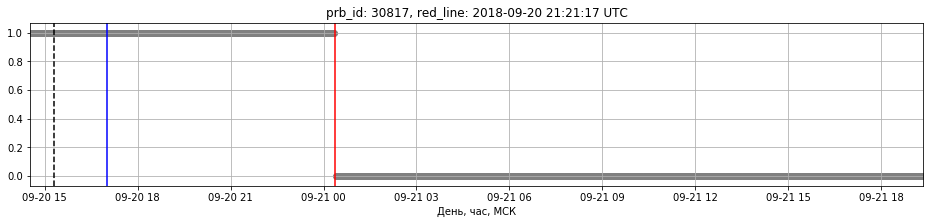

prb_id: 34854


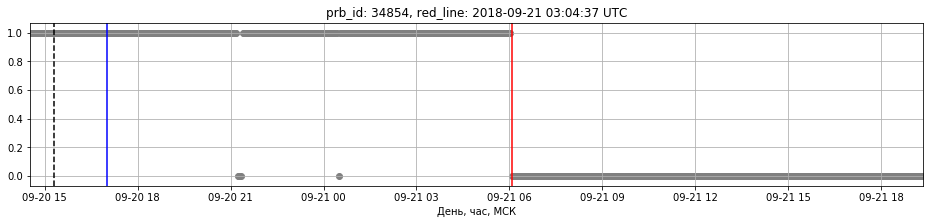

prb_id: 3953


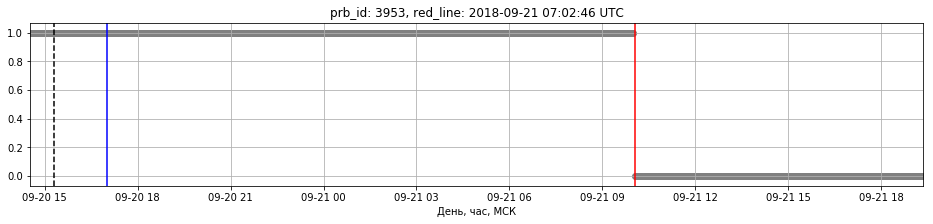

prb_id: 12642


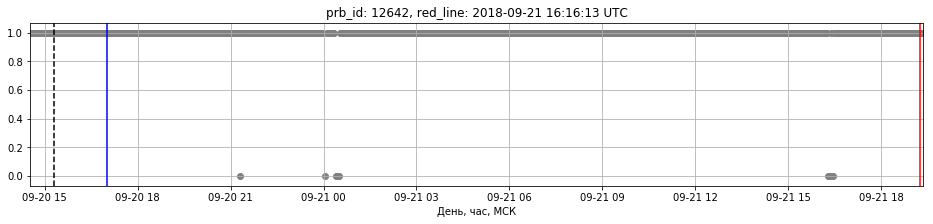

In [11]:
if PROBE_PLOT:
    for prb_id, red_dt in sorted(red_line.items(), key=lambda x: x[1]):
        prb = d[d.prb_id == prb_id]
        red_dt = pd.to_datetime(red_dt, unit='ns').floor('s')
                                 
        print 'prb_id: {}'.format(prb_id)
        f = figure(figsize=(16,3))
        xlim(d.timestamp.min(), d.timestamp.max())
        grid()
        f.axes[0].xaxis_date(TZ)
        xlabel(u'День, час, МСК')
        title('prb_id: {}, red_line: {} UTC'.format(prb_id, red_dt))
        scatter(list(prb.timestamp), prb.good_cert.astype('int'), color='grey')
        axvline(red_dt, color='red')
        axvline(blue_dt, color='blue')
        axvline(scan_dt, color='black', ls='--')
        show()

In [12]:
red = pd.DataFrame.from_records(red_line.items(), columns=['prb_id', 'line'])
red['dt'] = pd.to_datetime(red.line, unit='ns')
red.sort_values(by=['line'], inplace=True)
red.head()

,prb_id,line,dt
123,20873,1.537452e+18,2018-09-20 13:54:05.749366016
54,27858,1.537452e+18,2018-09-20 13:54:26.396821504
110,401,1.537452e+18,2018-09-20 13:54:33.396821248
96,35631,1.537452e+18,2018-09-20 13:54:33.546485248
101,10059,1.537452e+18,2018-09-20 13:55:15.433940992


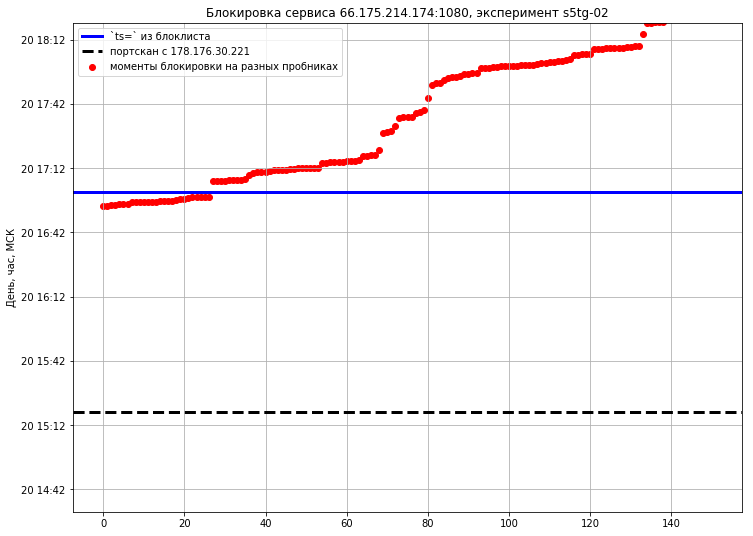

In [13]:
f = figure(figsize=(12,9))
ylim(d.timestamp.min(), red.dt.quantile(0.90))
axhline(blue_dt, color='blue', label=u'`ts=` из блоклиста', lw=3)
axhline(scan_dt, color='black', ls='--', label=u'портскан с 178.176.30.221', lw=3)
scatter(range(len(red.dt)), list(red.dt), color='red', label=u'моменты блокировки на разных пробниках')
title(u'Блокировка сервиса {}, эксперимент {}'.format(dst, experiment))
legend(loc='upper left')
ylabel(u'День, час, МСК')
f.axes[0].yaxis_date(TZ)
grid()
show()

In [14]:
the_fastest_draw = red[red.dt < blue_dt].copy()
the_fastest_draw['advance'] = blue_dt - the_fastest_draw.dt
the_fastest_draw.advance.describe()

count                        27
mean     0 days 00:04:24.336745
std      0 days 00:01:23.808878
min      0 days 00:02:17.503397
25%      0 days 00:03:17.525762
50%      0 days 00:04:36.639974
75%      0 days 00:05:18.177827
max      0 days 00:06:54.250633
Name: advance, dtype: object

In [15]:
ip_to_prb_id = dict(zip(d['from'], d.prb_id))

In [16]:
whois = []
if PROBE_PLOT:
    with requests.Session() as sess:
        for ip in set(d[d.prb_id.isin(the_fastest_draw.prb_id)]['from']):
            wh = sess.get('https://stat.ripe.net/data/prefix-overview/data.json?resource={}/32'.format(ip)).json()
            assert len(wh['data']['asns']) == 1
            whois.append({
                'ip': ip,
                'prb_id': ip_to_prb_id[ip],
                'resource': wh['data']['resource'],
                'asn': wh['data']['asns'][0]['asn'],
                'holder': wh['data']['asns'][0]['holder'],
            })

In [17]:
whois.sort(key=lambda x: (x['asn'], x['ip']))
pd.DataFrame(whois, columns=['ip', 'prb_id', 'resource', 'asn', 'holder'])

,ip,prb_id,resource,asn,holder
0,195.34.46.43,401,195.34.32.0/19,8359,MTS - MTS PJSC
1,195.34.46.44,241,195.34.32.0/19,8359,MTS - MTS PJSC
2,85.141.144.7,1227,85.140.0.0/15,8359,MTS - MTS PJSC
3,91.76.130.44,3815,91.76.0.0/14,8359,MTS - MTS PJSC
4,91.79.193.40,20873,91.76.0.0/14,8359,MTS - MTS PJSC
5,91.79.78.136,11098,91.76.0.0/14,8359,MTS - MTS PJSC
6,195.42.184.129,23973,195.42.160.0/19,8515,"DATAFORCE-AS - CJSC ""DataForce IP"""
7,193.232.224.27,10059,193.232.224.0/24,20821,"RUBIT-2-AS - Limited Liability Company ""Busine..."
8,109.252.105.219,3868,109.252.0.0/16,25513,ASN-MGTS-USPD - OJS Moscow city telephone network
9,109.252.14.245,14011,109.252.0.0/16,25513,ASN-MGTS-USPD - OJS Moscow city telephone network
